# 3. Feature Extraction, Transformations and Cleansing: 

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import seaborn as sns
%matplotlib inline
matplotlib.style.use("ggplot")

In [2]:
pd.set_option('display.max_columns', None)

## 3.1. Data Quality: nans, wrong data, etc.

### 1. File loading and examine:

#### Vamos a utilizar los data sets desde el 2000 hasta el 2016. Creamos un algoritmo que sea capaz de cargar y concatenar todos los archivos a la vez, previo a  empezar la limpieza

In [3]:
import glob

In [4]:
path =r'../tennis_atp-master/Prueba' # use your path
allFiles = glob.glob(path + "/*.csv")
frame = pd.DataFrame()
list_ = []
for file_ in allFiles:
    df = pd.read_csv(file_,index_col=None, header=0)
    list_.append(df)
frame = pd.concat(list_)

#### Despues de analizar el data set, he detectado datos incorrectos. Aplico el proceso de limpieza que hemos dictaminado como necesario:

In [5]:
# 1. Take out matchs from Davies Cup:
framesD = frame[frame['tourney_level'] != 'D']
# 2. Take out matchs from Challenge CUP:
framesDC = framesD[framesD['tourney_level'] != 'C']
# 3.1. Take out marchs'W/O' (Walk Over):
framesDCWO = framesDC[framesDC['score'] != 'W/O']
# 3.2. Take out marchs' W/O' (Walk Over):
framesDCWO = framesDCWO[framesDCWO['score'] != ' W/O']
# 4. Take out matchs with high volume of NaNs:
framesDCWO2 = framesDCWO.dropna(axis=0, thresh=30)

In [6]:
x = frame.shape
y = framesDCWO2.shape
print x
print y

(53120, 49)
(47085, 49)


La limpieza ha supuesto la eliminacion de 5.425 partidos, un 11,5% del total.

### 2. Analizamos las variables predictores:
    Cada linea del dataset contiene un partido, cada partido contiene 49 features que describen el torneo, los jugadores y las estadisticas de juego. De cara a modelizar este dataset tenemos que tener en cuenta que hay variables que no van a poder set utilizadas como variables explicativas, bien porque no esten disponibles antes del partido (ej. result, aces, etc.) o bien porque sean variables descriptivas (ej. date, name of the winner, etc.).
    Vamos a utilizar modelos de clasificacion en los que el resultado va a ser 1 gana el jugador A, 0 pierde el jugador A.
    Al tener variables de ambos jugadores podriamos elegir utilizar ambas o hacer una nueva feature con la diferencia entre ellas. Si utilizamos esta segunada visión cualquier partido podría tener un target de 1 o 0 en función de que jugador se ponga primero al hacer un estadístico, por tanto podemos decir que el modelo sería simetrico.
    A continuación vamos a analizar los tipos de variables:
   

#### a) Features constantes:
    Se mantienen constantes en cualquier partido
    1. Hand: Puede ser R o L. Vamos a convertirla en una variable categorica en la que 1 sera R y 0 sera L
    2. Best of: Numero de sets del partido, 3 o 5. Vamos a convertirla en una variable categoriaca en la que 1 sea 3 sets y 0 serán 5 sets.
    3. Height: Puede cambiar en el caso de jugadores muy jovenes, sin embargo, con objeto de simplificar el modelo la mantendremos constante.
    
#### b) Features variables, disponibles en cada partido:
    1. Age: 
    2. Rank/Rank points:
    3. Odds: Esta variable supone una de las claves del proyecto. Originalmente el objetivo de este era construir un modelo de ML que optimizara el ROI de nuestras apuestas. Para optimizar este resultado no solo es necesario tener un indice de acierto importante sino ademas tener en cuenta el retorno de cada acierto o perdida en caso de error. Por tanto para llevar a cabo este objetivo necesitariamos cambiar la funcion de coste de nuestro modelo incluyendo la variable odd. Es decir, la función de coste tiene que maximizar nuestras ganancias. Nuestra funcion de coste seria:
    
    J(w) = 1/2 E
    
    El objetivo de nuestro algoritmo es minimizar la función de coste al maximo. Si el resultado de la función de coste fuese 0 esto supondría que nuestra hipotesis h(x) obtiene la maxima rentabilidad posible.
    
    Dicho de otra manera si en un modelo normal la función de coste para minimizar la distancia suele ser el método de los minimos cuadrados, en este caso habría que ponderar esas distancias con la cantidad a recibir o a perder. 
    
    Para minimizar la función de coste podemos usar diferentes metodos:
    - Algoritmo de descenso del gradiente
    - Algoritmos de optimizacion avanzada
    
    Sin embargo dada la complejidad de este asunto, en este trabajo simplemente la utilizaremos como una variable descriptiva más, siendo el objetivo maximar el % de acierto.
    
#### c)Features variables, no disponibles en cada partido (requieren iteraciones):
    1. Average Minutes por partido
    2. Average Aces por partido
    3. Average Double Faults por partido
    4. % First In (w_1stIn/w_svpt)
    5. % First Won (w_1stWon / w_1stIn)
    6. % Second Won (w_2ndWon / (w_svpt - w_1stIn)) - Crear un estadistico de w_2ndIn
    7. % Break point won ( w_bpSaved / w_bpFaced)

    Hay que tener en cuenta que los partidos tienen una duración bien diferenciada según el torneo. Pueden ser torneos a 5 sets o a 3 sets, por tanto es necesario que separe el data set en dos para poder realizar los estadísticos y luego volver a juntarlo

#### d) Features varibles, no disponibles en cada partido (requieren iteraciones muy complejas)
    1. % Victorias en los ultimos 5 partidos
    2. % Victoria Head to Head
    3. % Victorias en los ultimos partidos Head to Head
    4. Surface: No utilizaremos esta variable como tal sino que vamos a poner el % de victorias sobre esa superfice (tendremos que implementar una iteración que busque el % partidos ganados sobre la superficie en que se juegue el partido)
    5. Tourney Level: No utilizaremos esta variable como tal sino que vamos a poner el % de victorias sobre esa superfice (tendremos que implementar una iteración que busque el % partidos ganados sobre la superficie en que se juegue el partido)
    
    Por tanto vamos a disponer de 18 features para poder modelizar.
    Crearemos ademas un variable Retires que utilizaremos para el problema de modelizacion del fraude, pero esto es algo aparte, como un segundo trabajo.

Voy a empezar limpiando el data set de todos aquellos campos que no vamos a utilizar, y creando alguna columna que utilizare en algun momento para crear otras variables.

In [7]:
columns = ['winner_seed', 'loser_seed', 'winner_entry', 'loser_entry']
framesDCWO2.drop(columns, inplace=True, axis=1) 

/Users/NachoSJ/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


In [8]:
framesDCWO2['TotalGames'] = framesDCWO2['w_SvGms'] + framesDCWO2['l_SvGms']

/Users/NachoSJ/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [9]:
framesDCWO2.head()

,tourney_id,tourney_name,surface,draw_size,tourney_level,tourney_date,match_num,winner_id,winner_name,winner_hand,winner_ht,winner_ioc,winner_age,winner_rank,winner_rank_points,loser_id,loser_name,loser_hand,loser_ht,loser_ioc,loser_age,loser_rank,loser_rank_points,score,best_of,round,minutes,w_ace,w_df,w_svpt,w_1stIn,w_1stWon,w_2ndWon,w_SvGms,w_bpSaved,w_bpFaced,l_ace,l_df,l_svpt,l_1stIn,l_1stWon,l_2ndWon,l_SvGms,l_bpSaved,l_bpFaced,TotalGames
0,2008-338,Sydney,Hard,32,A,20080107,1,104755,Richard Gasquet,R,185.0,FRA,21.555099,8.0,1930.0,104214,Igor Andreev,R,185.0,RUS,24.484600,34.0,890.0,6-3 7-6(6),3,R32,94.0,7.0,5.0,70.0,40.0,35.0,15.0,11.0,3.0,4.0,2.0,4.0,66.0,41.0,29.0,11.0,10.0,1.0,3.0,21.0
1,2008-338,Sydney,Hard,32,A,20080107,2,104098,Dmitry Tursunov,R,185.0,RUS,25.070500,35.0,853.0,104527,Stanislas Wawrinka,R,183.0,SUI,22.778919,28.0,995.0,6-3 6-3,3,R32,67.0,3.0,2.0,51.0,27.0,22.0,13.0,9.0,3.0,4.0,2.0,1.0,54.0,37.0,23.0,7.0,9.0,2.0,6.0,18.0
2,2008-338,Sydney,Hard,32,A,20080107,3,103206,Sebastien Grosjean,R,175.0,FRA,29.609856,51.0,621.0,103429,Peter Luczak,R,183.0,AUS,28.353183,90.0,464.0,6-4 4-6 6-0,3,R32,126.0,9.0,2.0,78.0,40.0,32.0,20.0,13.0,4.0,6.0,5.0,1.0,98.0,63.0,34.0,20.0,13.0,6.0,11.0,26.0
3,2008-338,Sydney,Hard,32,A,20080107,4,104269,Fernando Verdasco,L,188.0,ESP,24.145106,27.0,1050.0,103852,Feliciano Lopez,L,188.0,ESP,26.297057,36.0,840.0,6-3 4-6 6-2,3,R32,124.0,3.0,4.0,83.0,64.0,44.0,8.0,14.0,5.0,8.0,11.0,5.0,99.0,54.0,35.0,19.0,13.0,8.0,13.0,27.0
4,2008-338,Sydney,Hard,32,A,20080107,5,102148,Fabrice Santoro,R,178.0,FRA,35.077344,37.0,792.0,103484,James Blake,R,185.0,USA,28.027379,13.0,1710.0,7-6(4) 6-2,3,R32,80.0,5.0,2.0,68.0,27.0,18.0,23.0,10.0,5.0,8.0,3.0,1.0,57.0,31.0,21.0,10.0,10.0,2.0,7.0,20.0


In [10]:
framesDCWO2.shape

(47085, 46)

### 4. New Feature creation: Retired. This feature contemple aquellos partidos que no terminaron. Estos partidos están indicados en score, el campo que contiene el resultado, como retired:

In [11]:
Retired = []
for row in framesDCWO2['score']:
    if 'RET' in row:
        # Append 1
        Retired.append(1)
    # else, if not append 0,
    else:
        Retired.append(0)
# Create a column from the list
framesDCWO2['Retired'] = Retired

/Users/NachoSJ/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [12]:
Ret = framesDCWO2[framesDCWO2['Retired'] == 1 ]
Ret.shape

(1498, 47)

In [13]:
print "El data set tiene %d partidos no terminados por Retirada sobre un total de %d" %(len(Ret.index),
                                                                                        len(framesDCWO2.index))

El data set tiene 1498 partidos no terminados por Retirada sobre un total de 47085


#### Clasificados como Retired hay 1.498 partidos, lo que supone un 3,2%. Sabemos que hay algunos más que no han sido clasificados como Retired y que tendremos que buscar mas adelante (partido dura menos sets de los programados)

Estos partidos seguramente tendran las estadisticas condicionadas. Por tanto debemos quitarlos para evitar que contaminen el resto de partidos.

In [14]:
framesDCWO2 = framesDCWO2[framesDCWO2['Retired'] != 1]

In [15]:
framesDCWO2.shape

(45587, 47)

### 5. New feature creation: Hand (1 - Right hand, 0 - Left Hand)

In [16]:
Hand = {'R': 1,'L': 0}

In [17]:
framesDCWO2["w_hand"] = np.nan
framesDCWO2["l_hand"] = np.nan

In [18]:
framesDCWO2['w_hand'] = framesDCWO2['w_hand'].fillna(framesDCWO2['winner_hand'].map(Hand))
framesDCWO2['l_hand'] = framesDCWO2['l_hand'].fillna(framesDCWO2['loser_hand'].map(Hand))

In [19]:
framesDCWO2.head()

,tourney_id,tourney_name,surface,draw_size,tourney_level,tourney_date,match_num,winner_id,winner_name,winner_hand,winner_ht,winner_ioc,winner_age,winner_rank,winner_rank_points,loser_id,loser_name,loser_hand,loser_ht,loser_ioc,loser_age,loser_rank,loser_rank_points,score,best_of,round,minutes,w_ace,w_df,w_svpt,w_1stIn,w_1stWon,w_2ndWon,w_SvGms,w_bpSaved,w_bpFaced,l_ace,l_df,l_svpt,l_1stIn,l_1stWon,l_2ndWon,l_SvGms,l_bpSaved,l_bpFaced,TotalGames,Retired,w_hand,l_hand
0,2008-338,Sydney,Hard,32,A,20080107,1,104755,Richard Gasquet,R,185.0,FRA,21.555099,8.0,1930.0,104214,Igor Andreev,R,185.0,RUS,24.484600,34.0,890.0,6-3 7-6(6),3,R32,94.0,7.0,5.0,70.0,40.0,35.0,15.0,11.0,3.0,4.0,2.0,4.0,66.0,41.0,29.0,11.0,10.0,1.0,3.0,21.0,0,1.0,1.0
1,2008-338,Sydney,Hard,32,A,20080107,2,104098,Dmitry Tursunov,R,185.0,RUS,25.070500,35.0,853.0,104527,Stanislas Wawrinka,R,183.0,SUI,22.778919,28.0,995.0,6-3 6-3,3,R32,67.0,3.0,2.0,51.0,27.0,22.0,13.0,9.0,3.0,4.0,2.0,1.0,54.0,37.0,23.0,7.0,9.0,2.0,6.0,18.0,0,1.0,1.0
2,2008-338,Sydney,Hard,32,A,20080107,3,103206,Sebastien Grosjean,R,175.0,FRA,29.609856,51.0,621.0,103429,Peter Luczak,R,183.0,AUS,28.353183,90.0,464.0,6-4 4-6 6-0,3,R32,126.0,9.0,2.0,78.0,40.0,32.0,20.0,13.0,4.0,6.0,5.0,1.0,98.0,63.0,34.0,20.0,13.0,6.0,11.0,26.0,0,1.0,1.0
3,2008-338,Sydney,Hard,32,A,20080107,4,104269,Fernando Verdasco,L,188.0,ESP,24.145106,27.0,1050.0,103852,Feliciano Lopez,L,188.0,ESP,26.297057,36.0,840.0,6-3 4-6 6-2,3,R32,124.0,3.0,4.0,83.0,64.0,44.0,8.0,14.0,5.0,8.0,11.0,5.0,99.0,54.0,35.0,19.0,13.0,8.0,13.0,27.0,0,0.0,0.0
4,2008-338,Sydney,Hard,32,A,20080107,5,102148,Fabrice Santoro,R,178.0,FRA,35.077344,37.0,792.0,103484,James Blake,R,185.0,USA,28.027379,13.0,1710.0,7-6(4) 6-2,3,R32,80.0,5.0,2.0,68.0,27.0,18.0,23.0,10.0,5.0,8.0,3.0,1.0,57.0,31.0,21.0,10.0,10.0,2.0,7.0,20.0,0,1.0,1.0


 Voy a crear primero todos los pares de features y no haré las diferencias hasta el final. El motivo es que el dataset siempre esta ordenado con winner loser por tanto si aplicara la formula a-b a todo el dataset la Y siempre sería 1, es decir el resultado sería siempre victoria, y el modelo no funcionaria correctamente.
 
 Para solucionar este problema y poder incluir en el modelo partidos con el target 0, voy a aprovechar la simetría de mi modelo. Dividiré el data set en 2 utilizando la lógica siguiente para cada una de las partes:
 
 1 = winner - loser                  
 0 = - winner + loser

De esta forma voy a obtener un data set con resultados en ambos sentidos

### 6. New feature creation: Best of (1 - 3 sets, 0 - 5 sets)

In [20]:
Sets = {'5': 1,'3': 0}

In [21]:
framesDCWO2['best_of'] = framesDCWO2['best_of'].astype(str)

In [22]:
framesDCWO2['Total_Sets'] = np.nan

In [23]:
framesDCWO2['Total_Sets'] = framesDCWO2['Total_Sets'].fillna(framesDCWO2['best_of'].map(Sets))

In [24]:
framesDCWO2['Total_Sets'] = framesDCWO2['Total_Sets'].astype(int)

In [25]:
framesDCWO2.sample(5)

,tourney_id,tourney_name,surface,draw_size,tourney_level,tourney_date,match_num,winner_id,winner_name,winner_hand,winner_ht,winner_ioc,winner_age,winner_rank,winner_rank_points,loser_id,loser_name,loser_hand,loser_ht,loser_ioc,loser_age,loser_rank,loser_rank_points,score,best_of,round,minutes,w_ace,w_df,w_svpt,w_1stIn,w_1stWon,w_2ndWon,w_SvGms,w_bpSaved,w_bpFaced,l_ace,l_df,l_svpt,l_1stIn,l_1stWon,l_2ndWon,l_SvGms,l_bpSaved,l_bpFaced,TotalGames,Retired,w_hand,l_hand,Total_Sets
938,2016-0425,Barcelona,Clay,64,A,20160418,271,104871,Jeremy Chardy,R,188.0,FRA,29.180014,33.0,1220.0,103607,Victor Estrella,R,173.0,DOM,35.709788,78.0,705.0,7-5 6-2,3,R32,64.0,2.0,4.0,53.0,28.0,22.0,13.0,10.0,1.0,3.0,2.0,1.0,58.0,45.0,25.0,4.0,10.0,1.0,6.0,20.0,0,1.0,1.0,0
2718,2009-615,Dusseldorf,Clay,32,A,20090517,3,104542,Jo Wilfried Tsonga,R,188.0,FRA,24.084873,9.0,3430.0,104068,Robby Ginepri,R,183.0,USA,26.611910,58.0,1055.0,3-6 6-2 6-4,3,RR,105.0,4.0,4.0,86.0,58.0,35.0,18.0,14.0,6.0,10.0,2.0,1.0,87.0,60.0,36.0,10.0,13.0,4.0,9.0,27.0,0,1.0,1.0,0
452,2003-560,US Open,Hard,128,G,20030825,75,104068,Robby Ginepri,R,183.0,USA,20.881588,40.0,930.0,101965,Wayne Ferreira,R,185.0,RSA,31.942505,23.0,1225.0,6-2 6-4 6-7(0) 6-2,5,R64,130.0,7.0,3.0,119.0,80.0,56.0,23.0,19.0,2.0,4.0,9.0,2.0,116.0,67.0,44.0,23.0,19.0,6.0,13.0,38.0,0,1.0,1.0,1
369,2004-424,San Jose,Hard,32,A,20040209,20,102642,Cyril Saulnier,R,190.0,FRA,28.484600,73.0,485.0,104068,Robby Ginepri,R,183.0,USA,21.341547,25.0,1125.0,3-6 7-5 6-4,3,R16,113.0,11.0,7.0,92.0,43.0,37.0,21.0,15.0,9.0,12.0,6.0,2.0,98.0,51.0,38.0,23.0,16.0,8.0,12.0,31.0,0,1.0,1.0,0
2492,2001-573,Mallorca,Clay,32,A,20010430,29,103909,Guillermo Coria,R,175.0,ARG,19.293634,30.0,1022.0,102607,Juan Balcells,R,190.0,ESP,25.861739,62.0,668.0,4-6 6-3 7-5,3,SF,113.0,5.0,0.0,85.0,47.0,37.0,21.0,16.0,1.0,4.0,4.0,2.0,90.0,67.0,44.0,12.0,15.0,4.0,8.0,31.0,0,1.0,1.0,0


### 7. Solve *_ht (height) problem:

#### Ahora tenemos que hacer un diccionario con todos los *_ht que faltan:

In [26]:
framesDCWO2.isnull().sum()

tourney_id               0
tourney_name             0
surface                  0
draw_size                0
tourney_level            0
tourney_date             0
match_num                0
winner_id                0
winner_name              0
winner_hand              0
winner_ht             1383
winner_ioc               0
winner_age               0
winner_rank            587
winner_rank_points     587
loser_id                 0
loser_name               0
loser_hand               0
loser_ht              2545
loser_ioc                0
loser_age                2
loser_rank             672
loser_rank_points      672
score                    0
best_of                  0
round                    0
minutes               1247
w_ace                    0
w_df                     0
w_svpt                   0
w_1stIn                  0
w_1stWon                 0
w_2ndWon                 0
w_SvGms                  0
w_bpSaved                0
w_bpFaced                0
l_ace                    0
l

In [27]:
w_Names = {'Adrian Cruciat': 185,
 'Alejandro Gonzalez': 191,
 'Aleksandr Nedovyesov': 193,
 'Alexander Zverev': 191,
 'Alexandre Sidorenko': 185,
 'Ante Pavic': 196,
 'Augustin Gensse': 180,
 'Austin Krajicek': 188,
 'Axel Michon': 176,
 'Bastian Knittel': 180,
 'Blaz Rola': 193,
 'Borna Coric': 185,
 'Chris Eaton': 188,
 'Christian Garin': 185,
 'Christian Harrison': 180,
 'Christian Lindell': 193,
 'Chuhan Wang': 188,
 'Daniel Kosakowski': 185,
 'Daniel Munoz De La Nava': 178,
 'Dennis Novikov': 193,
 'Diego Sebastian Schwartzman': 170,
 'Dimitar Kutrovsky': 175,
 'Dominic Thiem': 185,
 'Elias Ymer': 183,
 'Emilio Gomez': 185,
 'Facundo Bagnis': 183,
 'Filip Peliwo': 178,
 'Gianluca Naso': 193,
 'Guido Pella': 185,
 'Guillermo Olaso': 175,
 'Gustavo Marcaccio': 170,
 'Henri Kontinen': 191,
 'Henri Laaksonen': 185,
 'Hiroki Kondo': 178,
 'Hiroki Moriya': 170,
 'Inigo Cervantes Huegun': 183,
 'Ivan Sergeyev': 175,
 'Jamie Baker': 183,
 'Jan Lennard Struff': 196,
 'Jaroslav Pospisil': 178,
 'Jason Kubler': 178,
 'Javier Marti': 185,
 'Jiri Vesely': 198,
 'Joao Sousa': 185,
 'Jonathan Dasnieres De Veigy': 175,
 'Jonathan Marray': 183,
 'Jorge Aguilar': 178,
 'Karen Khachanov': 198,
 'Kyle Edmund': 188,
 'Laurent Recouderc': 178,
 'Leonardo Tavares': 185,
 'Lucas Pouille': 185,
 'Luka Gregorc': 190,
 'Luke Saville': 188,
 'Marco Trungelliti': 180,
 'Martin Alund': 183,
 'Martin Fischer': 180,
 'Marton Fucsovics': 188,
 'Mate Delic': 196,
 'Mate Pavic': 193,
 'Mathieu Rodrigues': 180,
 'Matteo Viola': 185,
 'Maxime Teixeira': 188,
 'Miloslav Mecir': 196,
 'Mirza Basic': 188,
 'Nick Kyrgios': 193,
 'Nikola Milojevic': 188,
 'Nils Langer': 193,
 'Pablo Carreno Busta': 188,
 'Patrik Rosenholm': 178,
 'Pavol Cervenak': 191,
 'Peng Sun': 184,
 'Petar Jelenic': 190,
 'Philip Davydenko': 183,
 'Philipp Oswald': 201,
 'Pierre Hugues Herbert': 188,
 'Pierre Ludovic Duclos': 188,
 'Radu Albot': 175,
 'Rafael Arevalo': 180,
 'Ramkumar Ramanathan': 188,
 'Renzo Olivo': 180,
 'Rhyne Williams': 185,
 'Roberto Bautista Agut': 183,
 'Roberto Carballes Baena': 180,
 'Ruben Bemelmans': 183,
 'Samuel Groth': 193,
 'Sebastian Rieschick': 188,
 'Sergei Bubka': 188,
 'Takahiro Terachi': 174,
 'Taro Daniel': 191,
 'Thanasi Kokkinakis': 196,
 'Tim Puetz': 185,
 'Yan Bai': 185,
 'Yannick Mertens': 188,
 'Yuichi Sugita': 175,
 'Ze Zhang': 188}

In [28]:
framesDCWO2['winner_ht'] = framesDCWO2['winner_ht'].fillna(framesDCWO2['winner_name'].map(w_Names))

In [29]:
framesDCWO2['loser_ht'] = framesDCWO2['loser_ht'].fillna(framesDCWO2['loser_name'].map(w_Names))

### Antes de hacer ninguna variable tenemos que limpiar de Nans y demas, asi com incluir los odds

1. Limpiar de NaNs:

In [30]:
framesDCWO2.isnull().sum()

tourney_id               0
tourney_name             0
surface                  0
draw_size                0
tourney_level            0
tourney_date             0
match_num                0
winner_id                0
winner_name              0
winner_hand              0
winner_ht              210
winner_ioc               0
winner_age               0
winner_rank            587
winner_rank_points     587
loser_id                 0
loser_name               0
loser_hand               0
loser_ht               944
loser_ioc                0
loser_age                2
loser_rank             672
loser_rank_points      672
score                    0
best_of                  0
round                    0
minutes               1247
w_ace                    0
w_df                     0
w_svpt                   0
w_1stIn                  0
w_1stWon                 0
w_2ndWon                 0
w_SvGms                  0
w_bpSaved                0
w_bpFaced                0
l_ace                    0
l

In [31]:
framesDCWO2 = framesDCWO2.dropna()

In [32]:
framesDCWO2.isnull().sum()

tourney_id            0
tourney_name          0
surface               0
draw_size             0
tourney_level         0
tourney_date          0
match_num             0
winner_id             0
winner_name           0
winner_hand           0
winner_ht             0
winner_ioc            0
winner_age            0
winner_rank           0
winner_rank_points    0
loser_id              0
loser_name            0
loser_hand            0
loser_ht              0
loser_ioc             0
loser_age             0
loser_rank            0
loser_rank_points     0
score                 0
best_of               0
round                 0
minutes               0
w_ace                 0
w_df                  0
w_svpt                0
w_1stIn               0
w_1stWon              0
w_2ndWon              0
w_SvGms               0
w_bpSaved             0
w_bpFaced             0
l_ace                 0
l_df                  0
l_svpt                0
l_1stIn               0
l_1stWon              0
l_2ndWon        

In [33]:
framesDCWO2.shape

(42629, 50)

2. Buscar 0 en games para evitar generar Infinitos:

In [34]:
framesDCWO2['w_SvGms'].describe()

count    42629.000000
mean        12.587511
std          4.087738
min          0.000000
25%         10.000000
50%         11.000000
75%         15.000000
max         90.000000
Name: w_SvGms, dtype: float64

In [35]:
framesDCWO2['l_SvGms'].describe()

count    42629.000000
mean        12.386497
std          4.109074
min          0.000000
25%          9.000000
50%         11.000000
75%         15.000000
max         91.000000
Name: l_SvGms, dtype: float64

In [36]:
framesDCWO2[framesDCWO2['w_SvGms'] == 0]

,tourney_id,tourney_name,surface,draw_size,tourney_level,tourney_date,match_num,winner_id,winner_name,winner_hand,winner_ht,winner_ioc,winner_age,winner_rank,winner_rank_points,loser_id,loser_name,loser_hand,loser_ht,loser_ioc,loser_age,loser_rank,loser_rank_points,score,best_of,round,minutes,w_ace,w_df,w_svpt,w_1stIn,w_1stWon,w_2ndWon,w_SvGms,w_bpSaved,w_bpFaced,l_ace,l_df,l_svpt,l_1stIn,l_1stWon,l_2ndWon,l_SvGms,l_bpSaved,l_bpFaced,TotalGames,Retired,w_hand,l_hand,Total_Sets
2005,2009-580,Australian Open,Hard,128,G,20090119,92,103970,David Ferrer,R,175.0,ESP,26.800821,12.0,3390.0,103103,Dominik Hrbaty,R,183.0,SVK,31.041752,251.0,302.0,6-2 6-2 6-1,5,R64,90.0,1.0,0.0,18.0,12.0,11.0,3.0,0.0,0.0,0.0,0.0,0.0,16.0,7.0,4.0,4.0,4.0,0.0,2.0,4.0,0,1.0,1.0,1
414,2006-317,Amersfoort,Clay,32,A,20060717,8,105217,Thiemo De Bakker,R,193.0,NED,17.823409,1055.0,7.0,103898,Julien Benneteau,R,185.0,FRA,24.572211,53.0,711.0,6-3 6-3,3,R32,84.0,3.0,4.0,67.0,28.0,22.0,21.0,0.0,5.0,6.0,2.0,2.0,53.0,36.0,19.0,9.0,0.0,4.0,8.0,0.0,0,1.0,1.0,0


In [37]:
framesDCWO2[framesDCWO2['l_SvGms'] == 0]

,tourney_id,tourney_name,surface,draw_size,tourney_level,tourney_date,match_num,winner_id,winner_name,winner_hand,winner_ht,winner_ioc,winner_age,winner_rank,winner_rank_points,loser_id,loser_name,loser_hand,loser_ht,loser_ioc,loser_age,loser_rank,loser_rank_points,score,best_of,round,minutes,w_ace,w_df,w_svpt,w_1stIn,w_1stWon,w_2ndWon,w_SvGms,w_bpSaved,w_bpFaced,l_ace,l_df,l_svpt,l_1stIn,l_1stWon,l_2ndWon,l_SvGms,l_bpSaved,l_bpFaced,TotalGames,Retired,w_hand,l_hand,Total_Sets
1668,2008-580,Australian Open,Hard,128,G,20080114,49,104053,Andy Roddick,R,188.0,USA,25.374401,6.0,2530.0,104160,Lukas Dlouhy,R,185.0,CZE,24.766598,154.0,275.0,6-3 6-4 7-5,5,R128,98.0,13.0,2.0,89.0,58.0,44.0,18.0,16.0,5.0,7.0,7.0,12.0,88.0,49.0,33.0,16.0,0.0,6.0,11.0,16.0,0,1.0,1.0,1
2446,2011-747,Beijing,Hard,32,A,20111003,9,103344,Ivan Ljubicic,R,193.0,CRO,32.542094,26.0,1375.0,104559,Teymuraz Gabashvili,R,188.0,RUS,26.362765,128.0,432.0,7-5 7-5,3,R32,98.0,14.0,3.0,56.0,37.0,30.0,10.0,12.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12.0,0,1.0,1.0,0
2451,2011-747,Beijing,Hard,32,A,20111003,14,103656,Albert Montanes,R,175.0,ESP,30.850103,55.0,825.0,104154,Paul Capdeville,R,190.0,CHI,28.503765,103.0,563.0,6-3 6-3,3,R32,53.0,12.0,1.0,47.0,25.0,24.0,13.0,9.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9.0,0,1.0,1.0,0
414,2006-317,Amersfoort,Clay,32,A,20060717,8,105217,Thiemo De Bakker,R,193.0,NED,17.823409,1055.0,7.0,103898,Julien Benneteau,R,185.0,FRA,24.572211,53.0,711.0,6-3 6-3,3,R32,84.0,3.0,4.0,67.0,28.0,22.0,21.0,0.0,5.0,6.0,2.0,2.0,53.0,36.0,19.0,9.0,0.0,4.0,8.0,0.0,0,1.0,1.0,0


In [38]:
framesDCWO2 = framesDCWO2.drop(['414','2005','1668','2446','2451'])

In [39]:
framesDCWO2.shape

(42550, 50)

### 9. Average minutes per game:

Para poder hacer cualquier iteracion lo primero que tenemos que hacer es ordenar cronologicamente, ya que la iteración buscará la información en partidos pasados, obviando los partidos no ocurridos antes de esa fecha.
Basicamente la iteración buscará en cada partido para ambos jugadores los 'minutes' de todos aquellos partidos (aparezca como winner o loser) pasados. Para hacer la media simplemente sumará todos los minutes y lo dividirá por el total de partidos.

In [40]:
framesDCWO2 = framesDCWO2.sort_values(by=['tourney_date', 'match_num'])

In [41]:
framesDCWO2.head()

,tourney_id,tourney_name,surface,draw_size,tourney_level,tourney_date,match_num,winner_id,winner_name,winner_hand,winner_ht,winner_ioc,winner_age,winner_rank,winner_rank_points,loser_id,loser_name,loser_hand,loser_ht,loser_ioc,loser_age,loser_rank,loser_rank_points,score,best_of,round,minutes,w_ace,w_df,w_svpt,w_1stIn,w_1stWon,w_2ndWon,w_SvGms,w_bpSaved,w_bpFaced,l_ace,l_df,l_svpt,l_1stIn,l_1stWon,l_2ndWon,l_SvGms,l_bpSaved,l_bpFaced,TotalGames,Retired,w_hand,l_hand,Total_Sets
1141,2000-301,Auckland,Hard,32,A,20000110,1,103163,Tommy Haas,R,188.0,GER,21.771389,11.0,1612.0,101543,Jeff Tarango,L,180.0,USA,31.137577,63.0,595.0,7-5 4-6 7-5,3,R32,108.0,18.0,4.0,96.0,49.0,39.0,28.0,17.0,3.0,5.0,7.0,8.0,106.0,55.0,39.0,29.0,17.0,4.0,7.0,34.0,0,1.0,0.0,0
2980,2000-338,Sydney,Hard,32,A,20000110,1,101532,Francisco Clavet,L,183.0,ESP,31.211499,39.0,826.0,102856,Gustavo Kuerten,R,190.0,BRA,23.331964,5.0,2169.0,6-4 3-6 6-4,3,R32,114.0,1.0,1.0,85.0,54.0,44.0,14.0,14.0,4.0,5.0,6.0,8.0,100.0,56.0,48.0,19.0,15.0,6.0,8.0,29.0,0,0.0,1.0,0
1142,2000-301,Auckland,Hard,32,A,20000110,2,102607,Juan Balcells,R,190.0,ESP,24.558522,211.0,157.0,102644,Franco Squillari,L,183.0,ARG,24.386037,49.0,723.0,7-5 7-5,3,R32,85.0,5.0,3.0,76.0,52.0,39.0,13.0,12.0,5.0,6.0,5.0,10.0,74.0,32.0,25.0,18.0,12.0,3.0,6.0,24.0,0,1.0,0.0,0
2981,2000-338,Sydney,Hard,32,A,20000110,2,103720,Lleyton Hewitt,R,180.0,AUS,18.874743,21.0,1232.0,103206,Sebastien Grosjean,R,175.0,FRA,21.618070,27.0,1113.0,6-4 6-4,3,R32,93.0,6.0,4.0,70.0,43.0,32.0,10.0,10.0,4.0,6.0,4.0,0.0,63.0,35.0,21.0,14.0,10.0,3.0,7.0,20.0,0,1.0,1.0,0
1143,2000-301,Auckland,Hard,32,A,20000110,3,103252,Alberto Martin,R,175.0,ESP,21.390828,48.0,726.0,102238,Alberto Berasategui,R,173.0,ESP,26.535250,59.0,649.0,6-3 6-1,3,R32,56.0,0.0,0.0,55.0,35.0,25.0,12.0,8.0,1.0,1.0,0.0,6.0,56.0,33.0,20.0,7.0,8.0,7.0,11.0,16.0,0,1.0,1.0,0


Ahora ya puedo iterar.
En este punto existe la dificultadad de que la duracion del partido va a depender del desarrollo del mismo y además del tipo de torneo que se este jugando, existiendo torneros al mejor de 5 sets y torneos al mejor de 3 sets. Evidentemente la diferencia de tiempo entre uno y otro va a ser importante y no debemos utilizar el mismo estadistico para ambos.
Para solucionar este problema, vamos a convertir el tiempo a tiempo por juego (game). Por tanto después de obtener el total de juegos haremos las suma acumulativa de mas antiguo a mas reciente, dividiendo por el numero de juegos que hayamos acumulado para obtener una media. 

Vamos a ordenar el data set:

In [42]:
framesDCWO2 = framesDCWO2.set_index('tourney_date','match_num').sort_index()

In [43]:
framesDCWO2.head()

,tourney_id,tourney_name,surface,draw_size,tourney_level,match_num,winner_id,winner_name,winner_hand,winner_ht,winner_ioc,winner_age,winner_rank,winner_rank_points,loser_id,loser_name,loser_hand,loser_ht,loser_ioc,loser_age,loser_rank,loser_rank_points,score,best_of,round,minutes,w_ace,w_df,w_svpt,w_1stIn,w_1stWon,w_2ndWon,w_SvGms,w_bpSaved,w_bpFaced,l_ace,l_df,l_svpt,l_1stIn,l_1stWon,l_2ndWon,l_SvGms,l_bpSaved,l_bpFaced,TotalGames,Retired,w_hand,l_hand,Total_Sets
tourney_date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
20000110,2000-301,Auckland,Hard,32,A,1,103163,Tommy Haas,R,188.0,GER,21.771389,11.0,1612.0,101543,Jeff Tarango,L,180.0,USA,31.137577,63.0,595.0,7-5 4-6 7-5,3,R32,108.0,18.0,4.0,96.0,49.0,39.0,28.0,17.0,3.0,5.0,7.0,8.0,106.0,55.0,39.0,29.0,17.0,4.0,7.0,34.0,0,1.0,0.0,0
20000110,2000-338,Sydney,Hard,32,A,1,101532,Francisco Clavet,L,183.0,ESP,31.211499,39.0,826.0,102856,Gustavo Kuerten,R,190.0,BRA,23.331964,5.0,2169.0,6-4 3-6 6-4,3,R32,114.0,1.0,1.0,85.0,54.0,44.0,14.0,14.0,4.0,5.0,6.0,8.0,100.0,56.0,48.0,19.0,15.0,6.0,8.0,29.0,0,0.0,1.0,0
20000110,2000-301,Auckland,Hard,32,A,2,102607,Juan Balcells,R,190.0,ESP,24.558522,211.0,157.0,102644,Franco Squillari,L,183.0,ARG,24.386037,49.0,723.0,7-5 7-5,3,R32,85.0,5.0,3.0,76.0,52.0,39.0,13.0,12.0,5.0,6.0,5.0,10.0,74.0,32.0,25.0,18.0,12.0,3.0,6.0,24.0,0,1.0,0.0,0
20000110,2000-338,Sydney,Hard,32,A,2,103720,Lleyton Hewitt,R,180.0,AUS,18.874743,21.0,1232.0,103206,Sebastien Grosjean,R,175.0,FRA,21.618070,27.0,1113.0,6-4 6-4,3,R32,93.0,6.0,4.0,70.0,43.0,32.0,10.0,10.0,4.0,6.0,4.0,0.0,63.0,35.0,21.0,14.0,10.0,3.0,7.0,20.0,0,1.0,1.0,0
20000110,2000-301,Auckland,Hard,32,A,3,103252,Alberto Martin,R,175.0,ESP,21.390828,48.0,726.0,102238,Alberto Berasategui,R,173.0,ESP,26.535250,59.0,649.0,6-3 6-1,3,R32,56.0,0.0,0.0,55.0,35.0,25.0,12.0,8.0,1.0,1.0,0.0,6.0,56.0,33.0,20.0,7.0,8.0,7.0,11.0,16.0,0,1.0,1.0,0


Ahora ya podemos empezar a crear nuestras variables:

In [44]:
framesDCWO2['w_minutes_cum']=framesDCWO2.groupby('winner_name')['minutes'].transform(pd.Series.cumsum)

In [45]:
framesDCWO2.head()

,tourney_id,tourney_name,surface,draw_size,tourney_level,match_num,winner_id,winner_name,winner_hand,winner_ht,winner_ioc,winner_age,winner_rank,winner_rank_points,loser_id,loser_name,loser_hand,loser_ht,loser_ioc,loser_age,loser_rank,loser_rank_points,score,best_of,round,minutes,w_ace,w_df,w_svpt,w_1stIn,w_1stWon,w_2ndWon,w_SvGms,w_bpSaved,w_bpFaced,l_ace,l_df,l_svpt,l_1stIn,l_1stWon,l_2ndWon,l_SvGms,l_bpSaved,l_bpFaced,TotalGames,Retired,w_hand,l_hand,Total_Sets,w_minutes_cum
tourney_date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
20000110,2000-301,Auckland,Hard,32,A,1,103163,Tommy Haas,R,188.0,GER,21.771389,11.0,1612.0,101543,Jeff Tarango,L,180.0,USA,31.137577,63.0,595.0,7-5 4-6 7-5,3,R32,108.0,18.0,4.0,96.0,49.0,39.0,28.0,17.0,3.0,5.0,7.0,8.0,106.0,55.0,39.0,29.0,17.0,4.0,7.0,34.0,0,1.0,0.0,0,108.0
20000110,2000-338,Sydney,Hard,32,A,1,101532,Francisco Clavet,L,183.0,ESP,31.211499,39.0,826.0,102856,Gustavo Kuerten,R,190.0,BRA,23.331964,5.0,2169.0,6-4 3-6 6-4,3,R32,114.0,1.0,1.0,85.0,54.0,44.0,14.0,14.0,4.0,5.0,6.0,8.0,100.0,56.0,48.0,19.0,15.0,6.0,8.0,29.0,0,0.0,1.0,0,114.0
20000110,2000-301,Auckland,Hard,32,A,2,102607,Juan Balcells,R,190.0,ESP,24.558522,211.0,157.0,102644,Franco Squillari,L,183.0,ARG,24.386037,49.0,723.0,7-5 7-5,3,R32,85.0,5.0,3.0,76.0,52.0,39.0,13.0,12.0,5.0,6.0,5.0,10.0,74.0,32.0,25.0,18.0,12.0,3.0,6.0,24.0,0,1.0,0.0,0,85.0
20000110,2000-338,Sydney,Hard,32,A,2,103720,Lleyton Hewitt,R,180.0,AUS,18.874743,21.0,1232.0,103206,Sebastien Grosjean,R,175.0,FRA,21.618070,27.0,1113.0,6-4 6-4,3,R32,93.0,6.0,4.0,70.0,43.0,32.0,10.0,10.0,4.0,6.0,4.0,0.0,63.0,35.0,21.0,14.0,10.0,3.0,7.0,20.0,0,1.0,1.0,0,93.0
20000110,2000-301,Auckland,Hard,32,A,3,103252,Alberto Martin,R,175.0,ESP,21.390828,48.0,726.0,102238,Alberto Berasategui,R,173.0,ESP,26.535250,59.0,649.0,6-3 6-1,3,R32,56.0,0.0,0.0,55.0,35.0,25.0,12.0,8.0,1.0,1.0,0.0,6.0,56.0,33.0,20.0,7.0,8.0,7.0,11.0,16.0,0,1.0,1.0,0,56.0


In [46]:
framesDCWO2.tail()

,tourney_id,tourney_name,surface,draw_size,tourney_level,match_num,winner_id,winner_name,winner_hand,winner_ht,winner_ioc,winner_age,winner_rank,winner_rank_points,loser_id,loser_name,loser_hand,loser_ht,loser_ioc,loser_age,loser_rank,loser_rank_points,score,best_of,round,minutes,w_ace,w_df,w_svpt,w_1stIn,w_1stWon,w_2ndWon,w_SvGms,w_bpSaved,w_bpFaced,l_ace,l_df,l_svpt,l_1stIn,l_1stWon,l_2ndWon,l_SvGms,l_bpSaved,l_bpFaced,TotalGames,Retired,w_hand,l_hand,Total_Sets,w_minutes_cum
tourney_date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
20161114,2016-0605,London,Hard,8,A,296,104918,Andy Murray,R,190.0,GBR,29.503080,1.0,11185.0,105453,Kei Nishikori,R,178.0,JPN,26.877481,5.0,4705.0,6-7(9) 6-4 6-4,3,RR,200.0,8.0,4.0,132.0,70.0,53.0,30.0,16.0,9.0,11.0,0.0,6.0,119.0,75.0,54.0,18.0,16.0,3.0,7.0,32.0,0,1.0,1.0,0,61707.0
20161114,2016-0605,London,Hard,8,A,297,104918,Andy Murray,R,190.0,GBR,29.503080,1.0,11185.0,104527,Stanislas Wawrinka,R,183.0,SUI,31.633128,3.0,5115.0,6-4 6-2,3,RR,86.0,3.0,2.0,51.0,30.0,26.0,12.0,9.0,2.0,2.0,7.0,1.0,67.0,41.0,27.0,11.0,9.0,4.0,7.0,18.0,0,1.0,1.0,0,61793.0
20161114,2016-0605,London,Hard,8,A,298,104925,Novak Djokovic,R,188.0,SRB,29.483915,2.0,10780.0,105453,Kei Nishikori,R,178.0,JPN,26.877481,5.0,4705.0,6-1 6-1,3,SF,66.0,3.0,1.0,44.0,28.0,23.0,7.0,7.0,2.0,3.0,4.0,1.0,55.0,35.0,18.0,4.0,7.0,5.0,11.0,14.0,0,1.0,1.0,0,73312.0
20161114,2016-0605,London,Hard,8,A,299,104918,Andy Murray,R,190.0,GBR,29.503080,1.0,11185.0,105683,Milos Raonic,R,196.0,CAN,25.883641,4.0,5050.0,5-7 7-6(5) 7-6(9),3,SF,218.0,7.0,6.0,146.0,89.0,55.0,36.0,18.0,8.0,12.0,10.0,6.0,128.0,81.0,60.0,21.0,18.0,4.0,7.0,36.0,0,1.0,1.0,0,62011.0
20161114,2016-0605,London,Hard,8,A,300,104918,Andy Murray,R,190.0,GBR,29.503080,1.0,11185.0,104925,Novak Djokovic,R,188.0,SRB,29.483915,2.0,10780.0,6-3 6-4,3,F,103.0,3.0,3.0,59.0,32.0,27.0,13.0,10.0,0.0,1.0,1.0,0.0,61.0,44.0,26.0,11.0,9.0,6.0,9.0,19.0,0,1.0,1.0,0,62114.0


Ahora hay que crear otra columna que lleva la cuenta del numero de partidos, para poder hacer la media:

In [47]:
framesDCWO2['w_TotalGames_cum']=framesDCWO2.groupby('winner_name')['TotalGames'].transform(pd.Series.cumsum)

In [48]:
framesDCWO2.head()

,tourney_id,tourney_name,surface,draw_size,tourney_level,match_num,winner_id,winner_name,winner_hand,winner_ht,winner_ioc,winner_age,winner_rank,winner_rank_points,loser_id,loser_name,loser_hand,loser_ht,loser_ioc,loser_age,loser_rank,loser_rank_points,score,best_of,round,minutes,w_ace,w_df,w_svpt,w_1stIn,w_1stWon,w_2ndWon,w_SvGms,w_bpSaved,w_bpFaced,l_ace,l_df,l_svpt,l_1stIn,l_1stWon,l_2ndWon,l_SvGms,l_bpSaved,l_bpFaced,TotalGames,Retired,w_hand,l_hand,Total_Sets,w_minutes_cum,w_TotalGames_cum
tourney_date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
20000110,2000-301,Auckland,Hard,32,A,1,103163,Tommy Haas,R,188.0,GER,21.771389,11.0,1612.0,101543,Jeff Tarango,L,180.0,USA,31.137577,63.0,595.0,7-5 4-6 7-5,3,R32,108.0,18.0,4.0,96.0,49.0,39.0,28.0,17.0,3.0,5.0,7.0,8.0,106.0,55.0,39.0,29.0,17.0,4.0,7.0,34.0,0,1.0,0.0,0,108.0,34.0
20000110,2000-338,Sydney,Hard,32,A,1,101532,Francisco Clavet,L,183.0,ESP,31.211499,39.0,826.0,102856,Gustavo Kuerten,R,190.0,BRA,23.331964,5.0,2169.0,6-4 3-6 6-4,3,R32,114.0,1.0,1.0,85.0,54.0,44.0,14.0,14.0,4.0,5.0,6.0,8.0,100.0,56.0,48.0,19.0,15.0,6.0,8.0,29.0,0,0.0,1.0,0,114.0,29.0
20000110,2000-301,Auckland,Hard,32,A,2,102607,Juan Balcells,R,190.0,ESP,24.558522,211.0,157.0,102644,Franco Squillari,L,183.0,ARG,24.386037,49.0,723.0,7-5 7-5,3,R32,85.0,5.0,3.0,76.0,52.0,39.0,13.0,12.0,5.0,6.0,5.0,10.0,74.0,32.0,25.0,18.0,12.0,3.0,6.0,24.0,0,1.0,0.0,0,85.0,24.0
20000110,2000-338,Sydney,Hard,32,A,2,103720,Lleyton Hewitt,R,180.0,AUS,18.874743,21.0,1232.0,103206,Sebastien Grosjean,R,175.0,FRA,21.618070,27.0,1113.0,6-4 6-4,3,R32,93.0,6.0,4.0,70.0,43.0,32.0,10.0,10.0,4.0,6.0,4.0,0.0,63.0,35.0,21.0,14.0,10.0,3.0,7.0,20.0,0,1.0,1.0,0,93.0,20.0
20000110,2000-301,Auckland,Hard,32,A,3,103252,Alberto Martin,R,175.0,ESP,21.390828,48.0,726.0,102238,Alberto Berasategui,R,173.0,ESP,26.535250,59.0,649.0,6-3 6-1,3,R32,56.0,0.0,0.0,55.0,35.0,25.0,12.0,8.0,1.0,1.0,0.0,6.0,56.0,33.0,20.0,7.0,8.0,7.0,11.0,16.0,0,1.0,1.0,0,56.0,16.0


In [49]:
framesDCWO2.tail()

,tourney_id,tourney_name,surface,draw_size,tourney_level,match_num,winner_id,winner_name,winner_hand,winner_ht,winner_ioc,winner_age,winner_rank,winner_rank_points,loser_id,loser_name,loser_hand,loser_ht,loser_ioc,loser_age,loser_rank,loser_rank_points,score,best_of,round,minutes,w_ace,w_df,w_svpt,w_1stIn,w_1stWon,w_2ndWon,w_SvGms,w_bpSaved,w_bpFaced,l_ace,l_df,l_svpt,l_1stIn,l_1stWon,l_2ndWon,l_SvGms,l_bpSaved,l_bpFaced,TotalGames,Retired,w_hand,l_hand,Total_Sets,w_minutes_cum,w_TotalGames_cum
tourney_date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
20161114,2016-0605,London,Hard,8,A,296,104918,Andy Murray,R,190.0,GBR,29.503080,1.0,11185.0,105453,Kei Nishikori,R,178.0,JPN,26.877481,5.0,4705.0,6-7(9) 6-4 6-4,3,RR,200.0,8.0,4.0,132.0,70.0,53.0,30.0,16.0,9.0,11.0,0.0,6.0,119.0,75.0,54.0,18.0,16.0,3.0,7.0,32.0,0,1.0,1.0,0,61707.0,13502.0
20161114,2016-0605,London,Hard,8,A,297,104918,Andy Murray,R,190.0,GBR,29.503080,1.0,11185.0,104527,Stanislas Wawrinka,R,183.0,SUI,31.633128,3.0,5115.0,6-4 6-2,3,RR,86.0,3.0,2.0,51.0,30.0,26.0,12.0,9.0,2.0,2.0,7.0,1.0,67.0,41.0,27.0,11.0,9.0,4.0,7.0,18.0,0,1.0,1.0,0,61793.0,13520.0
20161114,2016-0605,London,Hard,8,A,298,104925,Novak Djokovic,R,188.0,SRB,29.483915,2.0,10780.0,105453,Kei Nishikori,R,178.0,JPN,26.877481,5.0,4705.0,6-1 6-1,3,SF,66.0,3.0,1.0,44.0,28.0,23.0,7.0,7.0,2.0,3.0,4.0,1.0,55.0,35.0,18.0,4.0,7.0,5.0,11.0,14.0,0,1.0,1.0,0,73312.0,15957.0
20161114,2016-0605,London,Hard,8,A,299,104918,Andy Murray,R,190.0,GBR,29.503080,1.0,11185.0,105683,Milos Raonic,R,196.0,CAN,25.883641,4.0,5050.0,5-7 7-6(5) 7-6(9),3,SF,218.0,7.0,6.0,146.0,89.0,55.0,36.0,18.0,8.0,12.0,10.0,6.0,128.0,81.0,60.0,21.0,18.0,4.0,7.0,36.0,0,1.0,1.0,0,62011.0,13556.0
20161114,2016-0605,London,Hard,8,A,300,104918,Andy Murray,R,190.0,GBR,29.503080,1.0,11185.0,104925,Novak Djokovic,R,188.0,SRB,29.483915,2.0,10780.0,6-3 6-4,3,F,103.0,3.0,3.0,59.0,32.0,27.0,13.0,10.0,0.0,1.0,1.0,0.0,61.0,44.0,26.0,11.0,9.0,6.0,9.0,19.0,0,1.0,1.0,0,62114.0,13575.0


#### OK. Ya tengo la cuenta. Ahora deberia ordenar correctamente el df y y obtener el resultado de:
    w_minutes_cum
    TotalGames_cum
    w_minutes_average = w_minutes_cum / TotalGames_cum
    

In [50]:
framesDCWO2['w_minutes_average'] = framesDCWO2['w_minutes_cum'] / framesDCWO2['w_TotalGames_cum']

In [51]:
framesDCWO2.tail()

,tourney_id,tourney_name,surface,draw_size,tourney_level,match_num,winner_id,winner_name,winner_hand,winner_ht,winner_ioc,winner_age,winner_rank,winner_rank_points,loser_id,loser_name,loser_hand,loser_ht,loser_ioc,loser_age,loser_rank,loser_rank_points,score,best_of,round,minutes,w_ace,w_df,w_svpt,w_1stIn,w_1stWon,w_2ndWon,w_SvGms,w_bpSaved,w_bpFaced,l_ace,l_df,l_svpt,l_1stIn,l_1stWon,l_2ndWon,l_SvGms,l_bpSaved,l_bpFaced,TotalGames,Retired,w_hand,l_hand,Total_Sets,w_minutes_cum,w_TotalGames_cum,w_minutes_average
tourney_date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
20161114,2016-0605,London,Hard,8,A,296,104918,Andy Murray,R,190.0,GBR,29.503080,1.0,11185.0,105453,Kei Nishikori,R,178.0,JPN,26.877481,5.0,4705.0,6-7(9) 6-4 6-4,3,RR,200.0,8.0,4.0,132.0,70.0,53.0,30.0,16.0,9.0,11.0,0.0,6.0,119.0,75.0,54.0,18.0,16.0,3.0,7.0,32.0,0,1.0,1.0,0,61707.0,13502.0,4.570212
20161114,2016-0605,London,Hard,8,A,297,104918,Andy Murray,R,190.0,GBR,29.503080,1.0,11185.0,104527,Stanislas Wawrinka,R,183.0,SUI,31.633128,3.0,5115.0,6-4 6-2,3,RR,86.0,3.0,2.0,51.0,30.0,26.0,12.0,9.0,2.0,2.0,7.0,1.0,67.0,41.0,27.0,11.0,9.0,4.0,7.0,18.0,0,1.0,1.0,0,61793.0,13520.0,4.570488
20161114,2016-0605,London,Hard,8,A,298,104925,Novak Djokovic,R,188.0,SRB,29.483915,2.0,10780.0,105453,Kei Nishikori,R,178.0,JPN,26.877481,5.0,4705.0,6-1 6-1,3,SF,66.0,3.0,1.0,44.0,28.0,23.0,7.0,7.0,2.0,3.0,4.0,1.0,55.0,35.0,18.0,4.0,7.0,5.0,11.0,14.0,0,1.0,1.0,0,73312.0,15957.0,4.594347
20161114,2016-0605,London,Hard,8,A,299,104918,Andy Murray,R,190.0,GBR,29.503080,1.0,11185.0,105683,Milos Raonic,R,196.0,CAN,25.883641,4.0,5050.0,5-7 7-6(5) 7-6(9),3,SF,218.0,7.0,6.0,146.0,89.0,55.0,36.0,18.0,8.0,12.0,10.0,6.0,128.0,81.0,60.0,21.0,18.0,4.0,7.0,36.0,0,1.0,1.0,0,62011.0,13556.0,4.574432
20161114,2016-0605,London,Hard,8,A,300,104918,Andy Murray,R,190.0,GBR,29.503080,1.0,11185.0,104925,Novak Djokovic,R,188.0,SRB,29.483915,2.0,10780.0,6-3 6-4,3,F,103.0,3.0,3.0,59.0,32.0,27.0,13.0,10.0,0.0,1.0,1.0,0.0,61.0,44.0,26.0,11.0,9.0,6.0,9.0,19.0,0,1.0,1.0,0,62114.0,13575.0,4.575617


In [52]:
framesDCWO2[framesDCWO2['winner_name'] == 'Andy Murray']

,tourney_id,tourney_name,surface,draw_size,tourney_level,match_num,winner_id,winner_name,winner_hand,winner_ht,winner_ioc,winner_age,winner_rank,winner_rank_points,loser_id,loser_name,loser_hand,loser_ht,loser_ioc,loser_age,loser_rank,loser_rank_points,score,best_of,round,minutes,w_ace,w_df,w_svpt,w_1stIn,w_1stWon,w_2ndWon,w_SvGms,w_bpSaved,w_bpFaced,l_ace,l_df,l_svpt,l_1stIn,l_1stWon,l_2ndWon,l_SvGms,l_bpSaved,l_bpFaced,TotalGames,Retired,w_hand,l_hand,Total_Sets,w_minutes_cum,w_TotalGames_cum,w_minutes_average
tourney_date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
20050606,2005-311,Queen's Club,Grass,56,A,11,104918,Andy Murray,R,190.0,GBR,18.061602,357.0,91.0,103490,Santiago Ventura,R,183.0,ESP,25.418207,110.0,381.0,6-1 6-2,3,R64,44.0,5.0,1.0,43.0,26.0,22.0,11.0,8.0,0.0,0.0,3.0,2.0,40.0,26.0,17.0,3.0,7.0,1.0,5.0,15.0,0,1.0,1.0,0,44.0,15.0,2.933333
20050606,2005-311,Queen's Club,Grass,56,A,31,104918,Andy Murray,R,190.0,GBR,18.061602,357.0,91.0,103758,Taylor Dent,R,188.0,USA,24.117728,30.0,1095.0,6-3 6-3,3,R32,62.0,7.0,4.0,52.0,27.0,24.0,14.0,9.0,2.0,2.0,2.0,3.0,56.0,25.0,17.0,17.0,9.0,1.0,4.0,18.0,0,1.0,1.0,0,106.0,33.0,3.212121
20050620,2005-540,Wimbledon,Grass,128,G,42,104918,Andy Murray,R,190.0,GBR,18.099932,312.0,111.0,102567,George Bastl,R,183.0,SUI,30.220397,146.0,304.0,6-4 6-2 6-2,5,R128,100.0,7.0,0.0,69.0,38.0,31.0,22.0,13.0,0.0,0.0,3.0,3.0,79.0,52.0,36.0,8.0,13.0,7.0,12.0,26.0,0,1.0,1.0,1,206.0,59.0,3.491525
20050620,2005-540,Wimbledon,Grass,128,G,85,104918,Andy Murray,R,190.0,GBR,18.099932,312.0,111.0,103285,Radek Stepanek,R,185.0,CZE,26.562628,13.0,1480.0,6-4 6-4 6-4,5,R64,110.0,8.0,2.0,86.0,41.0,37.0,25.0,15.0,3.0,4.0,5.0,3.0,93.0,64.0,44.0,14.0,15.0,5.0,9.0,30.0,0,1.0,1.0,1,316.0,89.0,3.550562
20050704,2005-315,Newport,Grass,32,A,7,104918,Andy Murray,R,190.0,GBR,18.138261,213.0,186.0,102571,Gregory Carraz,R,190.0,FRA,30.236824,126.0,348.0,6-4 7-5,3,R32,84.0,4.0,2.0,69.0,37.0,31.0,17.0,11.0,3.0,3.0,4.0,5.0,73.0,39.0,28.0,17.0,11.0,4.0,6.0,22.0,0,1.0,1.0,0,400.0,111.0,3.603604
20050718,2005-419,Indianapolis,Hard,48,A,6,104918,Andy Murray,R,190.0,GBR,18.176591,164.0,255.0,104070,Jesse Witten,R,178.0,USA,22.757016,401.0,69.0,6-4 6-2,3,R64,65.0,4.0,5.0,53.0,32.0,27.0,10.0,9.0,4.0,5.0,4.0,5.0,65.0,33.0,21.0,13.0,9.0,8.0,12.0,18.0,0,1.0,1.0,0,465.0,129.0,3.604651
20050815,2005-422,Cincinnati Masters,Hard,64,M,10,104918,Andy Murray,R,190.0,GBR,18.253251,132.0,329.0,103758,Taylor Dent,R,188.0,USA,24.309377,22.0,1340.0,7-6(4) 7-6(1),3,R64,105.0,4.0,4.0,77.0,43.0,34.0,19.0,12.0,0.0,2.0,6.0,11.0,84.0,41.0,32.0,20.0,12.0,2.0,4.0,24.0,0,1.0,1.0,0,570.0,153.0,3.725490
20050829,2005-560,US Open,Hard,128,G,6,104918,Andy Murray,R,190.0,GBR,18.291581,122.0,358.0,102318,Andrei Pavel,R,183.0,ROU,31.586585,39.0,855.0,6-3 3-6 3-6 6-1 6-4,5,R128,192.0,13.0,4.0,142.0,67.0,48.0,35.0,22.0,2.0,8.0,11.0,3.0,149.0,94.0,62.0,21.0,22.0,9.0,17.0,44.0,0,1.0,1.0,1,762.0,197.0,3.868020
20050926,2005-1720,Bangkok,Hard,32,A,10,104918,Andy Murray,R,190.0,GBR,18.368241,109.0,396.0,102567,George Bastl,R,183.0,SUI,30.488706,124.0,344.0,6-2 6-4,3,R32,88.0,7.0,3.0,55.0,26.0,22.0,14.0,9.0,1.0,2.0,2.0,2.0,72.0,46.0,26.0,10.0,9.0,9.0,13.0,18.0,0,1.0,1.0,0,850.0,215.0,3.953488


In [53]:
columns = ['w_minutes_cum']
framesDCWO2.drop(columns, inplace=True, axis=1) 

#### Voy a hacer lo mismo para el loser, pero sintetizando:

In [54]:
framesDCWO2['l_minutes_cum']=framesDCWO2.groupby('loser_name')['minutes'].transform(pd.Series.cumsum)
framesDCWO2['l_TotalGames_cum']=framesDCWO2.groupby('loser_name')['TotalGames'].transform(pd.Series.cumsum)
framesDCWO2['l_minutes_average'] = framesDCWO2['l_minutes_cum'] / framesDCWO2['l_TotalGames_cum']
columns = ['l_minutes_cum']
framesDCWO2.drop(columns, inplace=True, axis=1) 

In [55]:
framesDCWO2.tail()

,tourney_id,tourney_name,surface,draw_size,tourney_level,match_num,winner_id,winner_name,winner_hand,winner_ht,winner_ioc,winner_age,winner_rank,winner_rank_points,loser_id,loser_name,loser_hand,loser_ht,loser_ioc,loser_age,loser_rank,loser_rank_points,score,best_of,round,minutes,w_ace,w_df,w_svpt,w_1stIn,w_1stWon,w_2ndWon,w_SvGms,w_bpSaved,w_bpFaced,l_ace,l_df,l_svpt,l_1stIn,l_1stWon,l_2ndWon,l_SvGms,l_bpSaved,l_bpFaced,TotalGames,Retired,w_hand,l_hand,Total_Sets,w_TotalGames_cum,w_minutes_average,l_TotalGames_cum,l_minutes_average
tourney_date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
20161114,2016-0605,London,Hard,8,A,296,104918,Andy Murray,R,190.0,GBR,29.503080,1.0,11185.0,105453,Kei Nishikori,R,178.0,JPN,26.877481,5.0,4705.0,6-7(9) 6-4 6-4,3,RR,200.0,8.0,4.0,132.0,70.0,53.0,30.0,16.0,9.0,11.0,0.0,6.0,119.0,75.0,54.0,18.0,16.0,3.0,7.0,32.0,0,1.0,1.0,0,13502.0,4.570212,2701.0,4.596446
20161114,2016-0605,London,Hard,8,A,297,104918,Andy Murray,R,190.0,GBR,29.503080,1.0,11185.0,104527,Stanislas Wawrinka,R,183.0,SUI,31.633128,3.0,5115.0,6-4 6-2,3,RR,86.0,3.0,2.0,51.0,30.0,26.0,12.0,9.0,2.0,2.0,7.0,1.0,67.0,41.0,27.0,11.0,9.0,4.0,7.0,18.0,0,1.0,1.0,0,13520.0,4.570488,5830.0,4.584220
20161114,2016-0605,London,Hard,8,A,298,104925,Novak Djokovic,R,188.0,SRB,29.483915,2.0,10780.0,105453,Kei Nishikori,R,178.0,JPN,26.877481,5.0,4705.0,6-1 6-1,3,SF,66.0,3.0,1.0,44.0,28.0,23.0,7.0,7.0,2.0,3.0,4.0,1.0,55.0,35.0,18.0,4.0,7.0,5.0,11.0,14.0,0,1.0,1.0,0,15957.0,4.594347,2715.0,4.597053
20161114,2016-0605,London,Hard,8,A,299,104918,Andy Murray,R,190.0,GBR,29.503080,1.0,11185.0,105683,Milos Raonic,R,196.0,CAN,25.883641,4.0,5050.0,5-7 7-6(5) 7-6(9),3,SF,218.0,7.0,6.0,146.0,89.0,55.0,36.0,18.0,8.0,12.0,10.0,6.0,128.0,81.0,60.0,21.0,18.0,4.0,7.0,36.0,0,1.0,1.0,0,13556.0,4.574432,2912.0,4.331731
20161114,2016-0605,London,Hard,8,A,300,104918,Andy Murray,R,190.0,GBR,29.503080,1.0,11185.0,104925,Novak Djokovic,R,188.0,SRB,29.483915,2.0,10780.0,6-3 6-4,3,F,103.0,3.0,3.0,59.0,32.0,27.0,13.0,10.0,0.0,1.0,1.0,0.0,61.0,44.0,26.0,11.0,9.0,6.0,9.0,19.0,0,1.0,1.0,0,13575.0,4.575617,3660.0,4.825956


### 10. Average aces per game

Vamos a utilizar el mismo sistema, ir sumando los aces del partido y anteriores para hacer la media. Además también ponderamos si el partido es a 3 o 5 sets.

In [56]:
framesDCWO2['w_aces_cum']=framesDCWO2.groupby('winner_name')['w_ace'].transform(pd.Series.cumsum)
framesDCWO2['w_aces_average'] = framesDCWO2['w_aces_cum'] / framesDCWO2['w_TotalGames_cum']

framesDCWO2['l_aces_cum']=framesDCWO2.groupby('loser_name')['l_ace'].transform(pd.Series.cumsum)
framesDCWO2['l_aces_average'] = framesDCWO2['l_aces_cum'] / framesDCWO2['l_TotalGames_cum']

columns = ['w_aces_cum', 'l_aces_cum']
framesDCWO2.drop(columns, inplace=True, axis=1) 

In [57]:
framesDCWO2.tail()

,tourney_id,tourney_name,surface,draw_size,tourney_level,match_num,winner_id,winner_name,winner_hand,winner_ht,winner_ioc,winner_age,winner_rank,winner_rank_points,loser_id,loser_name,loser_hand,loser_ht,loser_ioc,loser_age,loser_rank,loser_rank_points,score,best_of,round,minutes,w_ace,w_df,w_svpt,w_1stIn,w_1stWon,w_2ndWon,w_SvGms,w_bpSaved,w_bpFaced,l_ace,l_df,l_svpt,l_1stIn,l_1stWon,l_2ndWon,l_SvGms,l_bpSaved,l_bpFaced,TotalGames,Retired,w_hand,l_hand,Total_Sets,w_TotalGames_cum,w_minutes_average,l_TotalGames_cum,l_minutes_average,w_aces_average,l_aces_average
tourney_date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
20161114,2016-0605,London,Hard,8,A,296,104918,Andy Murray,R,190.0,GBR,29.503080,1.0,11185.0,105453,Kei Nishikori,R,178.0,JPN,26.877481,5.0,4705.0,6-7(9) 6-4 6-4,3,RR,200.0,8.0,4.0,132.0,70.0,53.0,30.0,16.0,9.0,11.0,0.0,6.0,119.0,75.0,54.0,18.0,16.0,3.0,7.0,32.0,0,1.0,1.0,0,13502.0,4.570212,2701.0,4.596446,0.288105,0.102555
20161114,2016-0605,London,Hard,8,A,297,104918,Andy Murray,R,190.0,GBR,29.503080,1.0,11185.0,104527,Stanislas Wawrinka,R,183.0,SUI,31.633128,3.0,5115.0,6-4 6-2,3,RR,86.0,3.0,2.0,51.0,30.0,26.0,12.0,9.0,2.0,2.0,7.0,1.0,67.0,41.0,27.0,11.0,9.0,4.0,7.0,18.0,0,1.0,1.0,0,13520.0,4.570488,5830.0,4.584220,0.287944,0.210292
20161114,2016-0605,London,Hard,8,A,298,104925,Novak Djokovic,R,188.0,SRB,29.483915,2.0,10780.0,105453,Kei Nishikori,R,178.0,JPN,26.877481,5.0,4705.0,6-1 6-1,3,SF,66.0,3.0,1.0,44.0,28.0,23.0,7.0,7.0,2.0,3.0,4.0,1.0,55.0,35.0,18.0,4.0,7.0,5.0,11.0,14.0,0,1.0,1.0,0,15957.0,4.594347,2715.0,4.597053,0.228802,0.103499
20161114,2016-0605,London,Hard,8,A,299,104918,Andy Murray,R,190.0,GBR,29.503080,1.0,11185.0,105683,Milos Raonic,R,196.0,CAN,25.883641,4.0,5050.0,5-7 7-6(5) 7-6(9),3,SF,218.0,7.0,6.0,146.0,89.0,55.0,36.0,18.0,8.0,12.0,10.0,6.0,128.0,81.0,60.0,21.0,18.0,4.0,7.0,36.0,0,1.0,1.0,0,13556.0,4.574432,2912.0,4.331731,0.287695,0.462912
20161114,2016-0605,London,Hard,8,A,300,104918,Andy Murray,R,190.0,GBR,29.503080,1.0,11185.0,104925,Novak Djokovic,R,188.0,SRB,29.483915,2.0,10780.0,6-3 6-4,3,F,103.0,3.0,3.0,59.0,32.0,27.0,13.0,10.0,0.0,1.0,1.0,0.0,61.0,44.0,26.0,11.0,9.0,6.0,9.0,19.0,0,1.0,1.0,0,13575.0,4.575617,3660.0,4.825956,0.287514,0.181967


### 11. Average double foult per match

In [58]:
framesDCWO2['w_df_cum']=framesDCWO2.groupby('winner_name')['w_df'].transform(pd.Series.cumsum)
framesDCWO2['w_df_average'] = framesDCWO2['w_df_cum'] / framesDCWO2['w_TotalGames_cum']

framesDCWO2['l_df_cum']=framesDCWO2.groupby('loser_name')['l_df'].transform(pd.Series.cumsum)
framesDCWO2['l_df_average'] = framesDCWO2['l_df_cum'] / framesDCWO2['l_TotalGames_cum']

columns = ['w_df_cum', 'l_df_cum']
framesDCWO2.drop(columns, inplace=True, axis=1) 

In [59]:
framesDCWO2.tail()

,tourney_id,tourney_name,surface,draw_size,tourney_level,match_num,winner_id,winner_name,winner_hand,winner_ht,winner_ioc,winner_age,winner_rank,winner_rank_points,loser_id,loser_name,loser_hand,loser_ht,loser_ioc,loser_age,loser_rank,loser_rank_points,score,best_of,round,minutes,w_ace,w_df,w_svpt,w_1stIn,w_1stWon,w_2ndWon,w_SvGms,w_bpSaved,w_bpFaced,l_ace,l_df,l_svpt,l_1stIn,l_1stWon,l_2ndWon,l_SvGms,l_bpSaved,l_bpFaced,TotalGames,Retired,w_hand,l_hand,Total_Sets,w_TotalGames_cum,w_minutes_average,l_TotalGames_cum,l_minutes_average,w_aces_average,l_aces_average,w_df_average,l_df_average
tourney_date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
20161114,2016-0605,London,Hard,8,A,296,104918,Andy Murray,R,190.0,GBR,29.503080,1.0,11185.0,105453,Kei Nishikori,R,178.0,JPN,26.877481,5.0,4705.0,6-7(9) 6-4 6-4,3,RR,200.0,8.0,4.0,132.0,70.0,53.0,30.0,16.0,9.0,11.0,0.0,6.0,119.0,75.0,54.0,18.0,16.0,3.0,7.0,32.0,0,1.0,1.0,0,13502.0,4.570212,2701.0,4.596446,0.288105,0.102555,0.094727,0.138837
20161114,2016-0605,London,Hard,8,A,297,104918,Andy Murray,R,190.0,GBR,29.503080,1.0,11185.0,104527,Stanislas Wawrinka,R,183.0,SUI,31.633128,3.0,5115.0,6-4 6-2,3,RR,86.0,3.0,2.0,51.0,30.0,26.0,12.0,9.0,2.0,2.0,7.0,1.0,67.0,41.0,27.0,11.0,9.0,4.0,7.0,18.0,0,1.0,1.0,0,13520.0,4.570488,5830.0,4.584220,0.287944,0.210292,0.094749,0.112864
20161114,2016-0605,London,Hard,8,A,298,104925,Novak Djokovic,R,188.0,SRB,29.483915,2.0,10780.0,105453,Kei Nishikori,R,178.0,JPN,26.877481,5.0,4705.0,6-1 6-1,3,SF,66.0,3.0,1.0,44.0,28.0,23.0,7.0,7.0,2.0,3.0,4.0,1.0,55.0,35.0,18.0,4.0,7.0,5.0,11.0,14.0,0,1.0,1.0,0,15957.0,4.594347,2715.0,4.597053,0.228802,0.103499,0.088237,0.138490
20161114,2016-0605,London,Hard,8,A,299,104918,Andy Murray,R,190.0,GBR,29.503080,1.0,11185.0,105683,Milos Raonic,R,196.0,CAN,25.883641,4.0,5050.0,5-7 7-6(5) 7-6(9),3,SF,218.0,7.0,6.0,146.0,89.0,55.0,36.0,18.0,8.0,12.0,10.0,6.0,128.0,81.0,60.0,21.0,18.0,4.0,7.0,36.0,0,1.0,1.0,0,13556.0,4.574432,2912.0,4.331731,0.287695,0.462912,0.094940,0.120536
20161114,2016-0605,London,Hard,8,A,300,104918,Andy Murray,R,190.0,GBR,29.503080,1.0,11185.0,104925,Novak Djokovic,R,188.0,SRB,29.483915,2.0,10780.0,6-3 6-4,3,F,103.0,3.0,3.0,59.0,32.0,27.0,13.0,10.0,0.0,1.0,1.0,0.0,61.0,44.0,26.0,11.0,9.0,6.0,9.0,19.0,0,1.0,1.0,0,13575.0,4.575617,3660.0,4.825956,0.287514,0.181967,0.095028,0.113934


### 12. % First In (w_1stIn/game)

Como voy a hacer un ratio, no me interesa saber el numero de partidos. Voy a ir sumando todos los puntos servidos antes de ese partido y todos los 1st in, haciendo el ratio. Si ese ratio se obtuvo en 10 partidos o 1000 no es un factor que vayamos a utilizar.
Tampoco voy a utilizar la ponderacio de partidos a 3 o 5 sets, ya que al ser un ratio el resultado se va a mover siempre en la misma escala, entre 0-1, independientemente de la duración del mismo. Es evidente que si quisieramos ser puristas tendríamos que diferenciarlos porque el rendimiento de un tenista podría variar en los últimos sets por el cansancio o por una estrategia conservadora en los primeos sets.

In [60]:
framesDCWO2['w_1stIn_cum']=framesDCWO2.groupby('winner_name')['w_1stIn'].transform(pd.Series.cumsum)
framesDCWO2['w_SvGames_cum']=framesDCWO2.groupby('winner_name')['w_SvGms'].transform(pd.Series.cumsum)
framesDCWO2['w_1stIn_average'] = framesDCWO2['w_1stIn_cum'] / framesDCWO2['w_SvGames_cum']

framesDCWO2['l_1stIn_cum']=framesDCWO2.groupby('loser_name')['l_1stIn'].transform(pd.Series.cumsum)
framesDCWO2['l_SvGames_cum']=framesDCWO2.groupby('loser_name')['l_SvGms'].transform(pd.Series.cumsum)
framesDCWO2['l_1stIn_average'] = framesDCWO2['l_1stIn_cum'] / framesDCWO2['l_SvGames_cum']


columns = ['w_1stIn_cum', 'l_1stIn_cum']
framesDCWO2.drop(columns, inplace=True, axis=1) 

In [61]:
framesDCWO2.tail()

,tourney_id,tourney_name,surface,draw_size,tourney_level,match_num,winner_id,winner_name,winner_hand,winner_ht,winner_ioc,winner_age,winner_rank,winner_rank_points,loser_id,loser_name,loser_hand,loser_ht,loser_ioc,loser_age,loser_rank,loser_rank_points,score,best_of,round,minutes,w_ace,w_df,w_svpt,w_1stIn,w_1stWon,w_2ndWon,w_SvGms,w_bpSaved,w_bpFaced,l_ace,l_df,l_svpt,l_1stIn,l_1stWon,l_2ndWon,l_SvGms,l_bpSaved,l_bpFaced,TotalGames,Retired,w_hand,l_hand,Total_Sets,w_TotalGames_cum,w_minutes_average,l_TotalGames_cum,l_minutes_average,w_aces_average,l_aces_average,w_df_average,l_df_average,w_SvGames_cum,w_1stIn_average,l_SvGames_cum,l_1stIn_average
tourney_date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
20161114,2016-0605,London,Hard,8,A,296,104918,Andy Murray,R,190.0,GBR,29.503080,1.0,11185.0,105453,Kei Nishikori,R,178.0,JPN,26.877481,5.0,4705.0,6-7(9) 6-4 6-4,3,RR,200.0,8.0,4.0,132.0,70.0,53.0,30.0,16.0,9.0,11.0,0.0,6.0,119.0,75.0,54.0,18.0,16.0,3.0,7.0,32.0,0,1.0,1.0,0,13502.0,4.570212,2701.0,4.596446,0.288105,0.102555,0.094727,0.138837,6802.0,3.588650,1326.0,4.066365
20161114,2016-0605,London,Hard,8,A,297,104918,Andy Murray,R,190.0,GBR,29.503080,1.0,11185.0,104527,Stanislas Wawrinka,R,183.0,SUI,31.633128,3.0,5115.0,6-4 6-2,3,RR,86.0,3.0,2.0,51.0,30.0,26.0,12.0,9.0,2.0,2.0,7.0,1.0,67.0,41.0,27.0,11.0,9.0,4.0,7.0,18.0,0,1.0,1.0,0,13520.0,4.570488,5830.0,4.584220,0.287944,0.210292,0.094749,0.112864,6811.0,3.588313,2915.0,3.784220
20161114,2016-0605,London,Hard,8,A,298,104925,Novak Djokovic,R,188.0,SRB,29.483915,2.0,10780.0,105453,Kei Nishikori,R,178.0,JPN,26.877481,5.0,4705.0,6-1 6-1,3,SF,66.0,3.0,1.0,44.0,28.0,23.0,7.0,7.0,2.0,3.0,4.0,1.0,55.0,35.0,18.0,4.0,7.0,5.0,11.0,14.0,0,1.0,1.0,0,15957.0,4.594347,2715.0,4.597053,0.228802,0.103499,0.088237,0.138490,8119.0,3.959108,1333.0,4.071268
20161114,2016-0605,London,Hard,8,A,299,104918,Andy Murray,R,190.0,GBR,29.503080,1.0,11185.0,105683,Milos Raonic,R,196.0,CAN,25.883641,4.0,5050.0,5-7 7-6(5) 7-6(9),3,SF,218.0,7.0,6.0,146.0,89.0,55.0,36.0,18.0,8.0,12.0,10.0,6.0,128.0,81.0,60.0,21.0,18.0,4.0,7.0,36.0,0,1.0,1.0,0,13556.0,4.574432,2912.0,4.331731,0.287695,0.462912,0.094940,0.120536,6829.0,3.591888,1444.0,3.925900
20161114,2016-0605,London,Hard,8,A,300,104918,Andy Murray,R,190.0,GBR,29.503080,1.0,11185.0,104925,Novak Djokovic,R,188.0,SRB,29.483915,2.0,10780.0,6-3 6-4,3,F,103.0,3.0,3.0,59.0,32.0,27.0,13.0,10.0,0.0,1.0,1.0,0.0,61.0,44.0,26.0,11.0,9.0,6.0,9.0,19.0,0,1.0,1.0,0,13575.0,4.575617,3660.0,4.825956,0.287514,0.181967,0.095028,0.113934,6839.0,3.591315,1829.0,4.190268


####  Con esta manera de operar hacemos un doble estadistico para cadad jugador, uno cuando pierde y otro cuando gana. Concuptualmente hacerlo asi es correcto, porque lo que intentamos es poner etiquetas (ganador/perdedor) sobre los partidos. El mismo jugador con unas estadisticas puede ganar pero si las empeora podría perder.

In [62]:
x = framesDCWO2[framesDCWO2['winner_name'] == 'Rafael Nadal']['w_1stIn_average'].mean()
y = framesDCWO2[framesDCWO2['loser_name'] == 'Rafael Nadal']['l_1stIn_average'].mean()
print (x,y)

(4.23555215253495, 4.510577990387127)


### 13. % First Won (w_1stWon/game)

In [63]:
framesDCWO2['w_1stWon_cum']=framesDCWO2.groupby('winner_name')['w_1stWon'].transform(pd.Series.cumsum)
framesDCWO2['w_1stWon_average'] = framesDCWO2['w_1stWon_cum'] / framesDCWO2['w_SvGames_cum']

framesDCWO2['l_1stWon_cum']=framesDCWO2.groupby('loser_name')['l_1stWon'].transform(pd.Series.cumsum)
framesDCWO2['l_1stWon_average'] = framesDCWO2['l_1stWon_cum'] / framesDCWO2['l_SvGames_cum']


columns = ['w_1stWon_cum', 'l_1stWon_cum']
framesDCWO2.drop(columns, inplace=True, axis=1) 

In [64]:
framesDCWO2.tail()

,tourney_id,tourney_name,surface,draw_size,tourney_level,match_num,winner_id,winner_name,winner_hand,winner_ht,winner_ioc,winner_age,winner_rank,winner_rank_points,loser_id,loser_name,loser_hand,loser_ht,loser_ioc,loser_age,loser_rank,loser_rank_points,score,best_of,round,minutes,w_ace,w_df,w_svpt,w_1stIn,w_1stWon,w_2ndWon,w_SvGms,w_bpSaved,w_bpFaced,l_ace,l_df,l_svpt,l_1stIn,l_1stWon,l_2ndWon,l_SvGms,l_bpSaved,l_bpFaced,TotalGames,Retired,w_hand,l_hand,Total_Sets,w_TotalGames_cum,w_minutes_average,l_TotalGames_cum,l_minutes_average,w_aces_average,l_aces_average,w_df_average,l_df_average,w_SvGames_cum,w_1stIn_average,l_SvGames_cum,l_1stIn_average,w_1stWon_average,l_1stWon_average
tourney_date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
20161114,2016-0605,London,Hard,8,A,296,104918,Andy Murray,R,190.0,GBR,29.503080,1.0,11185.0,105453,Kei Nishikori,R,178.0,JPN,26.877481,5.0,4705.0,6-7(9) 6-4 6-4,3,RR,200.0,8.0,4.0,132.0,70.0,53.0,30.0,16.0,9.0,11.0,0.0,6.0,119.0,75.0,54.0,18.0,16.0,3.0,7.0,32.0,0,1.0,1.0,0,13502.0,4.570212,2701.0,4.596446,0.288105,0.102555,0.094727,0.138837,6802.0,3.588650,1326.0,4.066365,2.760512,2.604072
20161114,2016-0605,London,Hard,8,A,297,104918,Andy Murray,R,190.0,GBR,29.503080,1.0,11185.0,104527,Stanislas Wawrinka,R,183.0,SUI,31.633128,3.0,5115.0,6-4 6-2,3,RR,86.0,3.0,2.0,51.0,30.0,26.0,12.0,9.0,2.0,2.0,7.0,1.0,67.0,41.0,27.0,11.0,9.0,4.0,7.0,18.0,0,1.0,1.0,0,13520.0,4.570488,5830.0,4.584220,0.287944,0.210292,0.094749,0.112864,6811.0,3.588313,2915.0,3.784220,2.760681,2.558834
20161114,2016-0605,London,Hard,8,A,298,104925,Novak Djokovic,R,188.0,SRB,29.483915,2.0,10780.0,105453,Kei Nishikori,R,178.0,JPN,26.877481,5.0,4705.0,6-1 6-1,3,SF,66.0,3.0,1.0,44.0,28.0,23.0,7.0,7.0,2.0,3.0,4.0,1.0,55.0,35.0,18.0,4.0,7.0,5.0,11.0,14.0,0,1.0,1.0,0,15957.0,4.594347,2715.0,4.597053,0.228802,0.103499,0.088237,0.138490,8119.0,3.959108,1333.0,4.071268,2.964035,2.603901
20161114,2016-0605,London,Hard,8,A,299,104918,Andy Murray,R,190.0,GBR,29.503080,1.0,11185.0,105683,Milos Raonic,R,196.0,CAN,25.883641,4.0,5050.0,5-7 7-6(5) 7-6(9),3,SF,218.0,7.0,6.0,146.0,89.0,55.0,36.0,18.0,8.0,12.0,10.0,6.0,128.0,81.0,60.0,21.0,18.0,4.0,7.0,36.0,0,1.0,1.0,0,13556.0,4.574432,2912.0,4.331731,0.287695,0.462912,0.094940,0.120536,6829.0,3.591888,1444.0,3.925900,2.761458,2.994460
20161114,2016-0605,London,Hard,8,A,300,104918,Andy Murray,R,190.0,GBR,29.503080,1.0,11185.0,104925,Novak Djokovic,R,188.0,SRB,29.483915,2.0,10780.0,6-3 6-4,3,F,103.0,3.0,3.0,59.0,32.0,27.0,13.0,10.0,0.0,1.0,1.0,0.0,61.0,44.0,26.0,11.0,9.0,6.0,9.0,19.0,0,1.0,1.0,0,13575.0,4.575617,3660.0,4.825956,0.287514,0.181967,0.095028,0.113934,6839.0,3.591315,1829.0,4.190268,2.761369,2.791143


### 14. % Second Won (w_2ndWon/game)

In [65]:
framesDCWO2['w_2ndWon_cum']=framesDCWO2.groupby('winner_name')['w_2ndWon'].transform(pd.Series.cumsum)
framesDCWO2['w_2ndWon_average'] = framesDCWO2['w_2ndWon_cum'] / framesDCWO2['w_SvGames_cum']

framesDCWO2['l_2ndWon_cum']=framesDCWO2.groupby('loser_name')['l_2ndWon'].transform(pd.Series.cumsum)
framesDCWO2['l_2ndWon_average'] = framesDCWO2['l_2ndWon_cum'] / framesDCWO2['l_SvGames_cum']


columns = ['w_2ndWon_cum', 'l_2ndWon_cum']
framesDCWO2.drop(columns, inplace=True, axis=1) 

In [66]:
framesDCWO2.tail()

,tourney_id,tourney_name,surface,draw_size,tourney_level,match_num,winner_id,winner_name,winner_hand,winner_ht,winner_ioc,winner_age,winner_rank,winner_rank_points,loser_id,loser_name,loser_hand,loser_ht,loser_ioc,loser_age,loser_rank,loser_rank_points,score,best_of,round,minutes,w_ace,w_df,w_svpt,w_1stIn,w_1stWon,w_2ndWon,w_SvGms,w_bpSaved,w_bpFaced,l_ace,l_df,l_svpt,l_1stIn,l_1stWon,l_2ndWon,l_SvGms,l_bpSaved,l_bpFaced,TotalGames,Retired,w_hand,l_hand,Total_Sets,w_TotalGames_cum,w_minutes_average,l_TotalGames_cum,l_minutes_average,w_aces_average,l_aces_average,w_df_average,l_df_average,w_SvGames_cum,w_1stIn_average,l_SvGames_cum,l_1stIn_average,w_1stWon_average,l_1stWon_average,w_2ndWon_average,l_2ndWon_average
tourney_date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
20161114,2016-0605,London,Hard,8,A,296,104918,Andy Murray,R,190.0,GBR,29.503080,1.0,11185.0,105453,Kei Nishikori,R,178.0,JPN,26.877481,5.0,4705.0,6-7(9) 6-4 6-4,3,RR,200.0,8.0,4.0,132.0,70.0,53.0,30.0,16.0,9.0,11.0,0.0,6.0,119.0,75.0,54.0,18.0,16.0,3.0,7.0,32.0,0,1.0,1.0,0,13502.0,4.570212,2701.0,4.596446,0.288105,0.102555,0.094727,0.138837,6802.0,3.588650,1326.0,4.066365,2.760512,2.604072,1.387092,1.187783
20161114,2016-0605,London,Hard,8,A,297,104918,Andy Murray,R,190.0,GBR,29.503080,1.0,11185.0,104527,Stanislas Wawrinka,R,183.0,SUI,31.633128,3.0,5115.0,6-4 6-2,3,RR,86.0,3.0,2.0,51.0,30.0,26.0,12.0,9.0,2.0,2.0,7.0,1.0,67.0,41.0,27.0,11.0,9.0,4.0,7.0,18.0,0,1.0,1.0,0,13520.0,4.570488,5830.0,4.584220,0.287944,0.210292,0.094749,0.112864,6811.0,3.588313,2915.0,3.784220,2.760681,2.558834,1.387021,1.359863
20161114,2016-0605,London,Hard,8,A,298,104925,Novak Djokovic,R,188.0,SRB,29.483915,2.0,10780.0,105453,Kei Nishikori,R,178.0,JPN,26.877481,5.0,4705.0,6-1 6-1,3,SF,66.0,3.0,1.0,44.0,28.0,23.0,7.0,7.0,2.0,3.0,4.0,1.0,55.0,35.0,18.0,4.0,7.0,5.0,11.0,14.0,0,1.0,1.0,0,15957.0,4.594347,2715.0,4.597053,0.228802,0.103499,0.088237,0.138490,8119.0,3.959108,1333.0,4.071268,2.964035,2.603901,1.226136,1.184546
20161114,2016-0605,London,Hard,8,A,299,104918,Andy Murray,R,190.0,GBR,29.503080,1.0,11185.0,105683,Milos Raonic,R,196.0,CAN,25.883641,4.0,5050.0,5-7 7-6(5) 7-6(9),3,SF,218.0,7.0,6.0,146.0,89.0,55.0,36.0,18.0,8.0,12.0,10.0,6.0,128.0,81.0,60.0,21.0,18.0,4.0,7.0,36.0,0,1.0,1.0,0,13556.0,4.574432,2912.0,4.331731,0.287695,0.462912,0.094940,0.120536,6829.0,3.591888,1444.0,3.925900,2.761458,2.994460,1.388637,1.215374
20161114,2016-0605,London,Hard,8,A,300,104918,Andy Murray,R,190.0,GBR,29.503080,1.0,11185.0,104925,Novak Djokovic,R,188.0,SRB,29.483915,2.0,10780.0,6-3 6-4,3,F,103.0,3.0,3.0,59.0,32.0,27.0,13.0,10.0,0.0,1.0,1.0,0.0,61.0,44.0,26.0,11.0,9.0,6.0,9.0,19.0,0,1.0,1.0,0,13575.0,4.575617,3660.0,4.825956,0.287514,0.181967,0.095028,0.113934,6839.0,3.591315,1829.0,4.190268,2.761369,2.791143,1.388507,1.151996


### 15. % Break Point Saved (w_bpSaved/w_bpFaced)

In [67]:
framesDCWO2['w_bpSaved_cum']=framesDCWO2.groupby('winner_name')['w_bpSaved'].transform(pd.Series.cumsum)
framesDCWO2['w_bpFaced_cum']=framesDCWO2.groupby('winner_name')['w_bpFaced'].transform(pd.Series.cumsum)
framesDCWO2['w_bpSaved_average'] = framesDCWO2['w_bpSaved_cum'] / framesDCWO2['w_bpFaced_cum']

framesDCWO2['l_bpSaved_cum']=framesDCWO2.groupby('loser_name')['l_bpSaved'].transform(pd.Series.cumsum)
framesDCWO2['l_bpFaced_cum']=framesDCWO2.groupby('loser_name')['l_bpFaced'].transform(pd.Series.cumsum)
framesDCWO2['l_bpSaved_average'] = framesDCWO2['l_bpSaved_cum'] / framesDCWO2['l_bpFaced_cum']

columns = ['w_bpSaved_cum','w_bpFaced_cum', 'l_bpSaved_cum', 'l_bpFaced_cum']
framesDCWO2.drop(columns, inplace=True, axis=1) 

In [68]:
framesDCWO2.tail()

,tourney_id,tourney_name,surface,draw_size,tourney_level,match_num,winner_id,winner_name,winner_hand,winner_ht,winner_ioc,winner_age,winner_rank,winner_rank_points,loser_id,loser_name,loser_hand,loser_ht,loser_ioc,loser_age,loser_rank,loser_rank_points,score,best_of,round,minutes,w_ace,w_df,w_svpt,w_1stIn,w_1stWon,w_2ndWon,w_SvGms,w_bpSaved,w_bpFaced,l_ace,l_df,l_svpt,l_1stIn,l_1stWon,l_2ndWon,l_SvGms,l_bpSaved,l_bpFaced,TotalGames,Retired,w_hand,l_hand,Total_Sets,w_TotalGames_cum,w_minutes_average,l_TotalGames_cum,l_minutes_average,w_aces_average,l_aces_average,w_df_average,l_df_average,w_SvGames_cum,w_1stIn_average,l_SvGames_cum,l_1stIn_average,w_1stWon_average,l_1stWon_average,w_2ndWon_average,l_2ndWon_average,w_bpSaved_average,l_bpSaved_average
tourney_date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
20161114,2016-0605,London,Hard,8,A,296,104918,Andy Murray,R,190.0,GBR,29.503080,1.0,11185.0,105453,Kei Nishikori,R,178.0,JPN,26.877481,5.0,4705.0,6-7(9) 6-4 6-4,3,RR,200.0,8.0,4.0,132.0,70.0,53.0,30.0,16.0,9.0,11.0,0.0,6.0,119.0,75.0,54.0,18.0,16.0,3.0,7.0,32.0,0,1.0,1.0,0,13502.0,4.570212,2701.0,4.596446,0.288105,0.102555,0.094727,0.138837,6802.0,3.588650,1326.0,4.066365,2.760512,2.604072,1.387092,1.187783,0.661935,0.529171
20161114,2016-0605,London,Hard,8,A,297,104918,Andy Murray,R,190.0,GBR,29.503080,1.0,11185.0,104527,Stanislas Wawrinka,R,183.0,SUI,31.633128,3.0,5115.0,6-4 6-2,3,RR,86.0,3.0,2.0,51.0,30.0,26.0,12.0,9.0,2.0,2.0,7.0,1.0,67.0,41.0,27.0,11.0,9.0,4.0,7.0,18.0,0,1.0,1.0,0,13520.0,4.570488,5830.0,4.584220,0.287944,0.210292,0.094749,0.112864,6811.0,3.588313,2915.0,3.784220,2.760681,2.558834,1.387021,1.359863,0.662187,0.565641
20161114,2016-0605,London,Hard,8,A,298,104925,Novak Djokovic,R,188.0,SRB,29.483915,2.0,10780.0,105453,Kei Nishikori,R,178.0,JPN,26.877481,5.0,4705.0,6-1 6-1,3,SF,66.0,3.0,1.0,44.0,28.0,23.0,7.0,7.0,2.0,3.0,4.0,1.0,55.0,35.0,18.0,4.0,7.0,5.0,11.0,14.0,0,1.0,1.0,0,15957.0,4.594347,2715.0,4.597053,0.228802,0.103499,0.088237,0.138490,8119.0,3.959108,1333.0,4.071268,2.964035,2.603901,1.226136,1.184546,0.687212,0.528340
20161114,2016-0605,London,Hard,8,A,299,104918,Andy Murray,R,190.0,GBR,29.503080,1.0,11185.0,105683,Milos Raonic,R,196.0,CAN,25.883641,4.0,5050.0,5-7 7-6(5) 7-6(9),3,SF,218.0,7.0,6.0,146.0,89.0,55.0,36.0,18.0,8.0,12.0,10.0,6.0,128.0,81.0,60.0,21.0,18.0,4.0,7.0,36.0,0,1.0,1.0,0,13556.0,4.574432,2912.0,4.331731,0.287695,0.462912,0.094940,0.120536,6829.0,3.591888,1444.0,3.925900,2.761458,2.994460,1.388637,1.215374,0.662207,0.620991
20161114,2016-0605,London,Hard,8,A,300,104918,Andy Murray,R,190.0,GBR,29.503080,1.0,11185.0,104925,Novak Djokovic,R,188.0,SRB,29.483915,2.0,10780.0,6-3 6-4,3,F,103.0,3.0,3.0,59.0,32.0,27.0,13.0,10.0,0.0,1.0,1.0,0.0,61.0,44.0,26.0,11.0,9.0,6.0,9.0,19.0,0,1.0,1.0,0,13575.0,4.575617,3660.0,4.825956,0.287514,0.181967,0.095028,0.113934,6839.0,3.591315,1829.0,4.190268,2.761369,2.791143,1.388507,1.151996,0.661961,0.578191


## 3.2. Data Transformation:

#### 1. Creating new Features: Dif

Tengo listos los estadísticos de cada partido segmentados entre winner y loser. Como comentamos cuando hicimos el estudio inicial del data set, lo que vamos a introducir son las diferencias entre winner/loser para cada feature.
Para poder generar resultados 1 (win) y 0 (lose) tenemos que aplicar las formulas de la siguiente manera:
    1 = w - l
    0 = -w + l
Voy a aplicar cada fórmula a un 50% del dataset. 

In [69]:
framesDCWO2 = framesDCWO2.reset_index()

#### 1.1.1. dif_Minutes

In [70]:
framesDCWO2['dif_Minutes'] = framesDCWO2['w_minutes_average'] - framesDCWO2['l_minutes_average'] 
framesDCWO2.loc[1::2,'dif_Minutes'] = - framesDCWO2['w_minutes_average'] + framesDCWO2['l_minutes_average'] 
framesDCWO2.tail()

,tourney_date,tourney_id,tourney_name,surface,draw_size,tourney_level,match_num,winner_id,winner_name,winner_hand,winner_ht,winner_ioc,winner_age,winner_rank,winner_rank_points,loser_id,loser_name,loser_hand,loser_ht,loser_ioc,loser_age,loser_rank,loser_rank_points,score,best_of,round,minutes,w_ace,w_df,w_svpt,w_1stIn,w_1stWon,w_2ndWon,w_SvGms,w_bpSaved,w_bpFaced,l_ace,l_df,l_svpt,l_1stIn,l_1stWon,l_2ndWon,l_SvGms,l_bpSaved,l_bpFaced,TotalGames,Retired,w_hand,l_hand,Total_Sets,w_TotalGames_cum,w_minutes_average,l_TotalGames_cum,l_minutes_average,w_aces_average,l_aces_average,w_df_average,l_df_average,w_SvGames_cum,w_1stIn_average,l_SvGames_cum,l_1stIn_average,w_1stWon_average,l_1stWon_average,w_2ndWon_average,l_2ndWon_average,w_bpSaved_average,l_bpSaved_average,dif_Minutes
42545,20161114,2016-0605,London,Hard,8,A,296,104918,Andy Murray,R,190.0,GBR,29.503080,1.0,11185.0,105453,Kei Nishikori,R,178.0,JPN,26.877481,5.0,4705.0,6-7(9) 6-4 6-4,3,RR,200.0,8.0,4.0,132.0,70.0,53.0,30.0,16.0,9.0,11.0,0.0,6.0,119.0,75.0,54.0,18.0,16.0,3.0,7.0,32.0,0,1.0,1.0,0,13502.0,4.570212,2701.0,4.596446,0.288105,0.102555,0.094727,0.138837,6802.0,3.588650,1326.0,4.066365,2.760512,2.604072,1.387092,1.187783,0.661935,0.529171,0.026234
42546,20161114,2016-0605,London,Hard,8,A,297,104918,Andy Murray,R,190.0,GBR,29.503080,1.0,11185.0,104527,Stanislas Wawrinka,R,183.0,SUI,31.633128,3.0,5115.0,6-4 6-2,3,RR,86.0,3.0,2.0,51.0,30.0,26.0,12.0,9.0,2.0,2.0,7.0,1.0,67.0,41.0,27.0,11.0,9.0,4.0,7.0,18.0,0,1.0,1.0,0,13520.0,4.570488,5830.0,4.584220,0.287944,0.210292,0.094749,0.112864,6811.0,3.588313,2915.0,3.784220,2.760681,2.558834,1.387021,1.359863,0.662187,0.565641,-0.013731
42547,20161114,2016-0605,London,Hard,8,A,298,104925,Novak Djokovic,R,188.0,SRB,29.483915,2.0,10780.0,105453,Kei Nishikori,R,178.0,JPN,26.877481,5.0,4705.0,6-1 6-1,3,SF,66.0,3.0,1.0,44.0,28.0,23.0,7.0,7.0,2.0,3.0,4.0,1.0,55.0,35.0,18.0,4.0,7.0,5.0,11.0,14.0,0,1.0,1.0,0,15957.0,4.594347,2715.0,4.597053,0.228802,0.103499,0.088237,0.138490,8119.0,3.959108,1333.0,4.071268,2.964035,2.603901,1.226136,1.184546,0.687212,0.528340,0.002706
42548,20161114,2016-0605,London,Hard,8,A,299,104918,Andy Murray,R,190.0,GBR,29.503080,1.0,11185.0,105683,Milos Raonic,R,196.0,CAN,25.883641,4.0,5050.0,5-7 7-6(5) 7-6(9),3,SF,218.0,7.0,6.0,146.0,89.0,55.0,36.0,18.0,8.0,12.0,10.0,6.0,128.0,81.0,60.0,21.0,18.0,4.0,7.0,36.0,0,1.0,1.0,0,13556.0,4.574432,2912.0,4.331731,0.287695,0.462912,0.094940,0.120536,6829.0,3.591888,1444.0,3.925900,2.761458,2.994460,1.388637,1.215374,0.662207,0.620991,0.242701
42549,20161114,2016-0605,London,Hard,8,A,300,104918,Andy Murray,R,190.0,GBR,29.503080,1.0,11185.0,104925,Novak Djokovic,R,188.0,SRB,29.483915,2.0,10780.0,6-3 6-4,3,F,103.0,3.0,3.0,59.0,32.0,27.0,13.0,10.0,0.0,1.0,1.0,0.0,61.0,44.0,26.0,11.0,9.0,6.0,9.0,19.0,0,1.0,1.0,0,13575.0,4.575617,3660.0,4.825956,0.287514,0.181967,0.095028,0.113934,6839.0,3.591315,1829.0,4.190268,2.761369,2.791143,1.388507,1.151996,0.661961,0.578191,0.250339


#### 1.1.2. dif_Aces

In [71]:
framesDCWO2['dif_Aces'] = framesDCWO2['w_aces_average'] - framesDCWO2['l_aces_average'] 
framesDCWO2.loc[1::2,'dif_Aces'] = - framesDCWO2['w_aces_average'] + framesDCWO2['l_aces_average'] 

#### 1.1.3. dif_Df

In [72]:
framesDCWO2['dif_Df'] = framesDCWO2['w_df_average'] - framesDCWO2['l_df_average'] 
framesDCWO2.loc[1::2,'dif_Df'] = - framesDCWO2['w_df_average'] + framesDCWO2['l_df_average'] 

#### 1.1.4. dif_1stIn

In [73]:
framesDCWO2['dif_1stIn'] = framesDCWO2['w_1stIn_average'] - framesDCWO2['l_1stIn_average'] 
framesDCWO2.loc[1::2,'dif_1stIn'] = - framesDCWO2['w_1stIn_average'] + framesDCWO2['l_1stIn_average'] 

#### 1.1.5. dif_1stWon

In [74]:
framesDCWO2['dif_1stWon'] = framesDCWO2['w_1stWon_average'] - framesDCWO2['l_1stWon_average'] 
framesDCWO2.loc[1::2,'dif_1stWon'] = - framesDCWO2['w_1stWon_average'] + framesDCWO2['l_1stWon_average'] 

#### 1.1.6. dif_2ndWon

In [75]:
framesDCWO2['dif_2ndWon'] = framesDCWO2['w_2ndWon_average'] - framesDCWO2['l_2ndWon_average'] 
framesDCWO2.loc[1::2,'dif_2ndWon'] = - framesDCWO2['w_2ndWon_average'] + framesDCWO2['l_2ndWon_average'] 

#### 1.1.7. dif_BpSv

In [76]:
framesDCWO2['dif_BpSv'] = framesDCWO2['w_bpSaved_average'] - framesDCWO2['l_bpSaved_average'] 
framesDCWO2.loc[1::2,'dif_BpSv'] = - framesDCWO2['w_bpSaved_average'] + framesDCWO2['l_bpSaved_average'] 

Ahora vamos a volver a las primeras variables:

#### 1.1.8. dif_Age

In [77]:
framesDCWO2['dif_Age'] = framesDCWO2['winner_age'] - framesDCWO2['loser_age'] 
framesDCWO2.loc[1::2,'dif_Age'] = - framesDCWO2['winner_age'] + framesDCWO2['loser_age'] 

#### 1.1.9. dif_Height

In [78]:
framesDCWO2['dif_Height'] = framesDCWO2['winner_ht'] - framesDCWO2['loser_ht'] 
framesDCWO2.loc[1::2,'dif_Height'] = - framesDCWO2['winner_ht'] + framesDCWO2['loser_ht'] 

#### 1.1.10. dif_Rank

In [79]:
framesDCWO2['dif_Rank'] = framesDCWO2['winner_rank'] - framesDCWO2['loser_rank'] 
framesDCWO2.loc[1::2,'dif_Rank'] = - framesDCWO2['winner_rank'] + framesDCWO2['loser_rank'] 

#### 1.1.11. dif_RankP

In [80]:
framesDCWO2['dif_RankP'] = framesDCWO2['winner_rank_points'] - framesDCWO2['loser_rank_points'] 
framesDCWO2.loc[1::2,'dif_RankP'] = - framesDCWO2['winner_rank_points'] + framesDCWO2['loser_rank_points'] 

In [81]:
framesDCWO2.tail()

,tourney_date,tourney_id,tourney_name,surface,draw_size,tourney_level,match_num,winner_id,winner_name,winner_hand,winner_ht,winner_ioc,winner_age,winner_rank,winner_rank_points,loser_id,loser_name,loser_hand,loser_ht,loser_ioc,loser_age,loser_rank,loser_rank_points,score,best_of,round,minutes,w_ace,w_df,w_svpt,w_1stIn,w_1stWon,w_2ndWon,w_SvGms,w_bpSaved,w_bpFaced,l_ace,l_df,l_svpt,l_1stIn,l_1stWon,l_2ndWon,l_SvGms,l_bpSaved,l_bpFaced,TotalGames,Retired,w_hand,l_hand,Total_Sets,w_TotalGames_cum,w_minutes_average,l_TotalGames_cum,l_minutes_average,w_aces_average,l_aces_average,w_df_average,l_df_average,w_SvGames_cum,w_1stIn_average,l_SvGames_cum,l_1stIn_average,w_1stWon_average,l_1stWon_average,w_2ndWon_average,l_2ndWon_average,w_bpSaved_average,l_bpSaved_average,dif_Minutes,dif_Aces,dif_Df,dif_1stIn,dif_1stWon,dif_2ndWon,dif_BpSv,dif_Age,dif_Height,dif_Rank,dif_RankP
42545,20161114,2016-0605,London,Hard,8,A,296,104918,Andy Murray,R,190.0,GBR,29.503080,1.0,11185.0,105453,Kei Nishikori,R,178.0,JPN,26.877481,5.0,4705.0,6-7(9) 6-4 6-4,3,RR,200.0,8.0,4.0,132.0,70.0,53.0,30.0,16.0,9.0,11.0,0.0,6.0,119.0,75.0,54.0,18.0,16.0,3.0,7.0,32.0,0,1.0,1.0,0,13502.0,4.570212,2701.0,4.596446,0.288105,0.102555,0.094727,0.138837,6802.0,3.588650,1326.0,4.066365,2.760512,2.604072,1.387092,1.187783,0.661935,0.529171,0.026234,-0.185551,0.044111,0.477715,-0.156439,-0.199309,-0.132764,-2.625599,-12.0,4.0,-6480.0
42546,20161114,2016-0605,London,Hard,8,A,297,104918,Andy Murray,R,190.0,GBR,29.503080,1.0,11185.0,104527,Stanislas Wawrinka,R,183.0,SUI,31.633128,3.0,5115.0,6-4 6-2,3,RR,86.0,3.0,2.0,51.0,30.0,26.0,12.0,9.0,2.0,2.0,7.0,1.0,67.0,41.0,27.0,11.0,9.0,4.0,7.0,18.0,0,1.0,1.0,0,13520.0,4.570488,5830.0,4.584220,0.287944,0.210292,0.094749,0.112864,6811.0,3.588313,2915.0,3.784220,2.760681,2.558834,1.387021,1.359863,0.662187,0.565641,-0.013731,0.077652,-0.018116,-0.195907,0.201848,0.027158,0.096546,-2.130048,7.0,-2.0,6070.0
42547,20161114,2016-0605,London,Hard,8,A,298,104925,Novak Djokovic,R,188.0,SRB,29.483915,2.0,10780.0,105453,Kei Nishikori,R,178.0,JPN,26.877481,5.0,4705.0,6-1 6-1,3,SF,66.0,3.0,1.0,44.0,28.0,23.0,7.0,7.0,2.0,3.0,4.0,1.0,55.0,35.0,18.0,4.0,7.0,5.0,11.0,14.0,0,1.0,1.0,0,15957.0,4.594347,2715.0,4.597053,0.228802,0.103499,0.088237,0.138490,8119.0,3.959108,1333.0,4.071268,2.964035,2.603901,1.226136,1.184546,0.687212,0.528340,0.002706,-0.125303,0.050253,0.112160,-0.360134,-0.041590,-0.158872,-2.606434,-10.0,3.0,-6075.0
42548,20161114,2016-0605,London,Hard,8,A,299,104918,Andy Murray,R,190.0,GBR,29.503080,1.0,11185.0,105683,Milos Raonic,R,196.0,CAN,25.883641,4.0,5050.0,5-7 7-6(5) 7-6(9),3,SF,218.0,7.0,6.0,146.0,89.0,55.0,36.0,18.0,8.0,12.0,10.0,6.0,128.0,81.0,60.0,21.0,18.0,4.0,7.0,36.0,0,1.0,1.0,0,13556.0,4.574432,2912.0,4.331731,0.287695,0.462912,0.094940,0.120536,6829.0,3.591888,1444.0,3.925900,2.761458,2.994460,1.388637,1.215374,0.662207,0.620991,0.242701,-0.175217,-0.025596,-0.334013,-0.233001,0.173263,0.041216,3.619439,-6.0,-3.0,6135.0
42549,20161114,2016-0605,London,Hard,8,A,300,104918,Andy Murray,R,190.0,GBR,29.503080,1.0,11185.0,104925,Novak Djokovic,R,188.0,SRB,29.483915,2.0,10780.0,6-3 6-4,3,F,103.0,3.0,3.0,59.0,32.0,27.0,13.0,10.0,0.0,1.0,1.0,0.0,61.0,44.0,26.0,11.0,9.0,6.0,9.0,19.0,0,1.0,1.0,0,13575.0,4.575617,3660.0,4.825956,0.287514,0.181967,0.095028,0.113934,6839.0,3.591315,1829.0,4.190268,2.761369,2.791143,1.388507,1.151996,0.661961,0.578191,0.250339,-0.105547,0.018907,0.598953,0.029774,-0.236511,-0.083770,-0.019165,-2.0,1.0,-405.0


In [82]:
framesDCWO2.isnull().sum()

tourney_date           0
tourney_id             0
tourney_name           0
surface                0
draw_size              0
tourney_level          0
match_num              0
winner_id              0
winner_name            0
winner_hand            0
winner_ht              0
winner_ioc             0
winner_age             0
winner_rank            0
winner_rank_points     0
loser_id               0
loser_name             0
loser_hand             0
loser_ht               0
loser_ioc              0
loser_age              0
loser_rank             0
loser_rank_points      0
score                  0
best_of                0
round                  0
minutes                0
w_ace                  0
w_df                   0
w_svpt                 0
                      ..
Total_Sets             0
w_TotalGames_cum       0
w_minutes_average      0
l_TotalGames_cum       0
l_minutes_average      0
w_aces_average         0
l_aces_average         0
w_df_average           0
l_df_average           0


## El otro tipo de estadisticos:
a) Ultimos 5 partidos:

In [83]:
#df["sum4"] = df.groupby("Type")["Value"].apply(lambda x: pd.rolling_sum(x,4))

In [84]:
### Probar doble group by para los últimos 5 partidos

## TARGET:

Vamos a crear el vector Y siguiendo la lógica aplicada con anterioridad. Las lineas impares contienen victorias (w-l),
mientras que las líneas pares contiene derrotas (-w+l). Por tanto, codificaremos como 1 las lineas impares y 0 las lineas pares.

In [85]:
framesDCWO2['Y'] = 1
framesDCWO2.loc[1::2,'Y'] = 0

Generamos el dataframe definitivo incluyendo todas las features que vamos a utilizar:

In [86]:
TennisDF = framesDCWO2[['Y','dif_Rank','dif_RankP','dif_Height','dif_Age','w_hand','l_hand','dif_Minutes','dif_Aces',
                        'dif_Df','dif_1stIn','dif_1stWon', 'dif_2ndWon','dif_BpSv']]             

In [87]:
TennisDF.shape

(42550, 14)

In [88]:
TennisDF.head()

,Y,dif_Rank,dif_RankP,dif_Height,dif_Age,w_hand,l_hand,dif_Minutes,dif_Aces,dif_Df,dif_1stIn,dif_1stWon,dif_2ndWon,dif_BpSv
0,1,-52.0,1017.0,8.0,-9.366188,1.0,0.0,0.0,0.323529,-0.117647,-0.352941,0.000000,-0.058824,0.028571
1,0,-34.0,1343.0,7.0,-7.879535,0.0,1.0,0.0,0.172414,0.241379,-0.123810,0.057143,0.266667,-0.050000
2,1,162.0,-566.0,7.0,0.172485,1.0,0.0,0.0,0.000000,-0.291667,1.666667,1.166667,-0.416667,0.333333
3,0,6.0,-119.0,-5.0,2.743326,1.0,1.0,0.0,-0.100000,-0.200000,-0.800000,-1.100000,0.400000,-0.238095
4,1,-11.0,77.0,2.0,-5.144422,1.0,1.0,0.0,0.000000,-0.375000,0.250000,0.625000,0.625000,0.363636


In [89]:
TennisDF.isnull().sum()

Y               0
dif_Rank        0
dif_RankP       0
dif_Height      0
dif_Age         0
w_hand          0
l_hand          0
dif_Minutes     0
dif_Aces        0
dif_Df          0
dif_1stIn       0
dif_1stWon      0
dif_2ndWon      0
dif_BpSv       41
dtype: int64

In [90]:
TennisDF = TennisDF.dropna()

In [91]:
TennisDF.shape

(42509, 14)

In [92]:
TennisDF.isnull().sum()

Y              0
dif_Rank       0
dif_RankP      0
dif_Height     0
dif_Age        0
w_hand         0
l_hand         0
dif_Minutes    0
dif_Aces       0
dif_Df         0
dif_1stIn      0
dif_1stWon     0
dif_2ndWon     0
dif_BpSv       0
dtype: int64

In [93]:
TennisDF.dtypes

Y                int64
dif_Rank       float64
dif_RankP      float64
dif_Height     float64
dif_Age        float64
w_hand         float64
l_hand         float64
dif_Minutes    float64
dif_Aces       float64
dif_Df         float64
dif_1stIn      float64
dif_1stWon     float64
dif_2ndWon     float64
dif_BpSv       float64
dtype: object

In [94]:
TennisDF.min(), TennisDF.max()

(Y                  0.000000
 dif_Rank       -1507.000000
 dif_RankP     -16092.000000
 dif_Height       -43.000000
 dif_Age          -25.921971
 w_hand             0.000000
 l_hand             0.000000
 dif_Minutes       -4.007906
 dif_Aces          -0.999838
 dif_Df            -0.427169
 dif_1stIn         -3.296887
 dif_1stWon        -2.234244
 dif_2ndWon        -1.589286
 dif_BpSv          -1.000000
 dtype: float64, Y                  1.000000
 dif_Rank        1798.000000
 dif_RankP      16641.000000
 dif_Height        43.000000
 dif_Age           19.468857
 w_hand             1.000000
 l_hand             1.000000
 dif_Minutes       11.441529
 dif_Aces           0.711905
 dif_Df             0.600000
 dif_1stIn          2.953446
 dif_1stWon         2.285714
 dif_2ndWon         1.407463
 dif_BpSv           0.833333
 dtype: float64)

## 3.2. Data Transformation:

#### 1. Creating new Features: Sets

In [95]:
# Separo los sets:
#framesDCWO2['s1'], framesDCWO2['s5'] = framesDCWO2['score'].str.split(' ', 1).str
#framesDCWO2['s2'], framesDCWO2['s5'] = framesDCWO2['s5'].str.split(' ', 1).str
#framesDCWO2['s3'], framesDCWO2['s5'] = framesDCWO2['s5'].str.split(' ', 1).str
#framesDCWO2['s4'], framesDCWO2['s5'] = framesDCWO2['s5'].str.split(' ', 1).str
# Separo los juegos:
#framesDCWO2['w_s1'], framesDCWO2['l_s1'] = framesDCWO2['s1'].str.split('-', 1).str
#framesDCWO2['w_s2'], framesDCWO2['l_s2'] = framesDCWO2['s2'].str.split('-', 1).str
#framesDCWO2['w_s3'], framesDCWO2['l_s3'] = framesDCWO2['s3'].str.split('-', 1).str
#framesDCWO2['w_s4'], framesDCWO2['l_s4'] = framesDCWO2['s4'].str.split('-', 1).str
#framesDCWO2['w_s5'], framesDCWO2['l_s5'] = framesDCWO2['s5'].str.split('-', 1).str
# Quito los tiebreaks

#### 2. Eliminating Features:

In [96]:
#el framesDCWO2['s1']
#del framesDCWO2['s2']
#del framesDCWO2['s3']
#del framesDCWO2['s4']
#del framesDCWO2['s5']
# Cuando repase todo hacer reengeniere:
# df.drop(df.columns[[0, 1, 3]], axis=1)

In [97]:
#framesDCWO2.columns

## 3.3. Data Analisis:

### 3.3.1. Feature distribution:

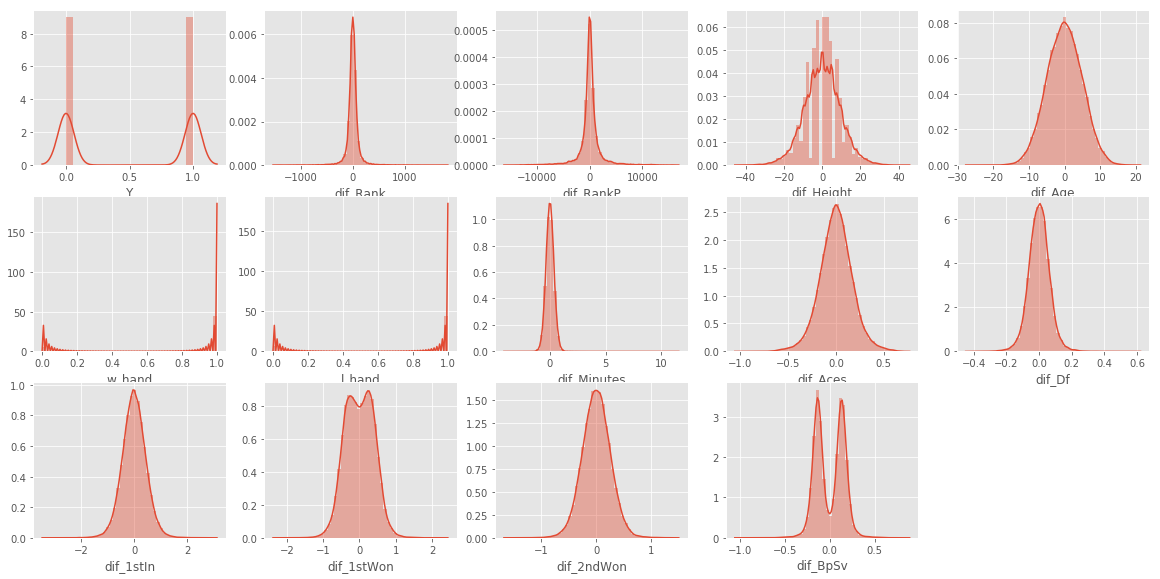

In [98]:
plt.figure(figsize=(20,20))
for index,col in enumerate(TennisDF.columns):
    plt.subplot(6,5,index+1)
    sns.distplot(TennisDF[col])

#### Antes de introducir las variables en el modelo vamos a estandarizarlas, pero no voy a estandarizar todas, evidentemente la variable Y no.

METODO 1:

Lo primero que voy a hacer es separar los data sets, en dos, una para los predictores y otro para el target.

In [99]:
TennisDF_X = TennisDF[['dif_Rank','dif_RankP','dif_Height','dif_Age','w_hand','l_hand','dif_Minutes','dif_Aces',
                        'dif_Df','dif_1stIn','dif_1stWon', 'dif_2ndWon','dif_BpSv']]

In [100]:
TennisDF_Y = TennisDF['Y']

In [101]:
TennisDFnorm_X = TennisDF_X.apply(lambda x: (x - np.mean(x)) / (np.std(x)))

In [102]:
TennisDFnorm_X.head()

,dif_Rank,dif_RankP,dif_Height,dif_Age,w_hand,l_hand,dif_Minutes,dif_Aces,dif_Df,dif_1stIn,dif_1stWon,dif_2ndWon,dif_BpSv
0,-0.429112,0.480356,0.845264,-1.907903,0.368448,-2.576821,-0.004915,1.895517,-1.833948,-0.789742,0.001725,-0.230945,0.181169
1,-0.278954,0.634250,0.738884,-1.603764,-2.714087,0.388075,-0.004915,1.009726,3.755639,-0.275683,0.146904,1.047744,-0.319451
2,1.356094,-0.266931,0.738884,0.043516,0.368448,-2.576821,-0.004915,-0.000907,-4.543214,3.741265,2.965791,-1.636733,2.122969
3,0.054729,-0.055915,-0.537676,0.569459,0.368448,0.388075,-0.004915,-0.587074,-3.116080,-1.792722,-2.792965,1.571545,-1.517906
4,-0.087086,0.036610,0.206984,-1.044215,0.368448,0.388075,-0.004915,-0.000907,-5.840609,0.562962,1.589617,2.455458,2.316045


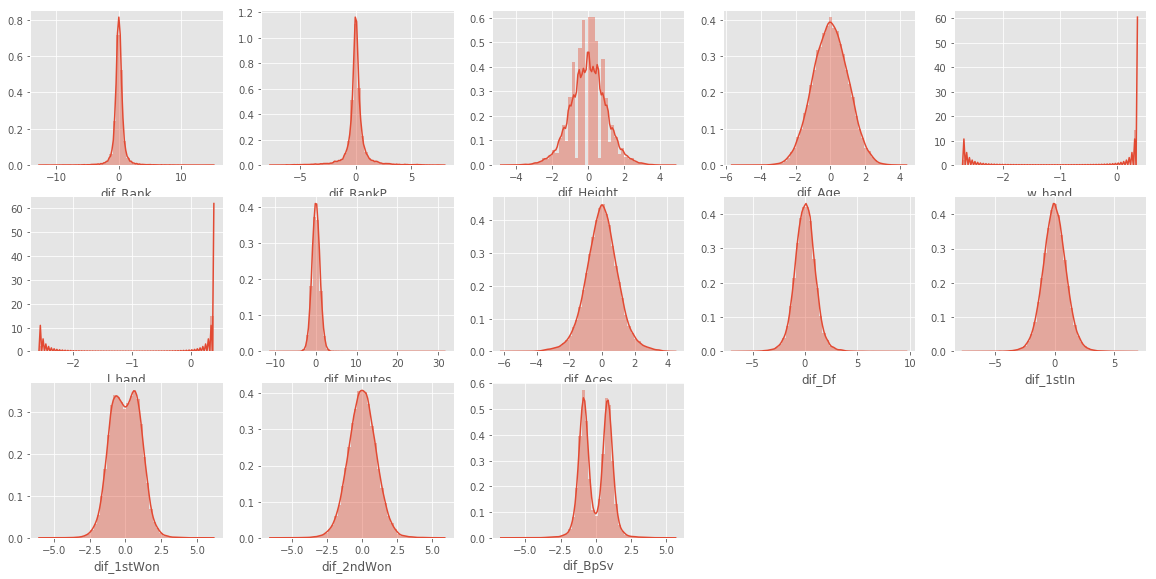

In [103]:
plt.figure(figsize=(20,20))
for index,col in enumerate(TennisDFnorm_X.columns):
    plt.subplot(6,5,index+1)
    sns.distplot(TennisDFnorm_X[col])

Parece que la mayor parte de las variables tienen una distribución normal, con mayor o menor dispersion

In [104]:
TennisDFnorm_X['dif_Aces'].std(), TennisDFnorm_X['dif_Aces'].median()

(1.000011762422584, 0.0032719733522802398)

In [105]:
TennisDFnorm_X['dif_Age'].std(), TennisDFnorm_X['dif_Age'].median()

(1.0000117624225726, 0.0015081396382973576)

 Si analizamos por ejemplo dif_Aces o Dif_Age podemos comprobar que la mayor parte de los valores se encuentran contenidos en el intervalo que comprende la mediana y 3 veces su desviación.

METODO 2:

In [106]:
#X = (TennisDF[TennisDF.columns[1:13]]).values
#X_norm = preprocessing.scale((TennisDF[TennisDF.columns[1:13]]).values)

In [107]:
#X_norm

In [108]:
#y = TennisDF['Y']

El resultado del metod 1 y 2 coinciden

# 5. Modeling the data:

## 5.1. Base line model:

Vamos a buscar un escenario base para poder medir los progresos de nuestros modelos. Para este escenario utilizaré dif_Rank, algo que es sencillo de obtener y de interpretar. El indice de acierto debería mejorar el propio azar, aunque con un resultado muy bajo.

METODO 1:

In [109]:
from sklearn import linear_model
from sklearn.cross_validation import train_test_split

/Users/NachoSJ/anaconda/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [110]:
X = TennisDFnorm_X[['dif_Rank']]
y = TennisDF['Y']

In [111]:
logreg = linear_model.LogisticRegression()

In [112]:
logreg.fit(X, y)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [113]:
logreg.score(X, y, sample_weight=None)

0.65701380884048088

Esto no es del todo correcto, debería separar el dataframe en un set para entrenar el modelo y otro para hacer el test. De esta forma obtendremos un modelo más realista.

In [114]:
X_train,X_test,y_train,y_test = train_test_split(X, y)

In [115]:
logreg.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [116]:
logreg.score(X_test, y_test, sample_weight=None)

0.66174256680466692

In [117]:
from sklearn.model_selection import cross_val_score

In [118]:
cross_val_score(logreg, X_test, y_test,cv=5) 

array([ 0.66698024,  0.65286924,  0.66180621,  0.66541176,  0.66258824])

In [119]:
#cross_val_score(logreg, X_test, y_test,cv=5).average

#### Antes de utilizar todas las variables en el target tengo que estar seguro de que ninguna de ellas está muy correlacionada o contiene el target. Tengo que analizar las que me generen dudas:

In [120]:
X = TennisDFnorm_X[['dif_1stIn']]

In [121]:
X_train,X_test,y_train,y_test = train_test_split(X, y)
logreg.fit(X_train, y_train)
cross_val_score(logreg, X_test, y_test,cv=5) 

array([ 0.58251058,  0.57761054,  0.58870588,  0.58682353,  0.592     ])

In [122]:
X = TennisDFnorm_X[['dif_2ndWon']]

In [123]:
X_train,X_test,y_train,y_test = train_test_split(X, y)
logreg.fit(X_train, y_train)
cross_val_score(logreg, X_test, y_test,cv=5) 

array([ 0.71636877,  0.7158984 ,  0.71401693,  0.72624647,  0.70951036])

In [124]:
X = TennisDFnorm_X[['dif_1stWon']]

In [125]:
X_train,X_test,y_train,y_test = train_test_split(X, y)
logreg.fit(X_train, y_train)
cross_val_score(logreg, X_test, y_test,cv=5) 

array([ 0.85841957,  0.87394167,  0.85559737,  0.8537159 ,  0.87099812])

In [126]:
X = TennisDFnorm_X[['dif_BpSv']]

In [127]:
X_train,X_test,y_train,y_test = train_test_split(X, y)
logreg.fit(X_train, y_train)
cross_val_score(logreg, X_test, y_test,cv=5) 

array([ 0.97036689,  0.97460019,  0.96989652,  0.97223529,  0.96564706])

Como habiamos previsto estas dos magnitudes combinan el total de puntos jugados, pasados a la primera, metidos a la primera y segunda. Evidentemente con toda esta información, simplemente sumando, podemos obtener el ganador. Tenemos que quitarlos del data set.

In [128]:
del TennisDFnorm_X['dif_1stWon']
del TennisDFnorm_X['dif_2ndWon']
del TennisDFnorm_X['dif_BpSv']

In [129]:
X = TennisDFnorm_X

In [130]:
X.head()

,dif_Rank,dif_RankP,dif_Height,dif_Age,w_hand,l_hand,dif_Minutes,dif_Aces,dif_Df,dif_1stIn
0,-0.429112,0.480356,0.845264,-1.907903,0.368448,-2.576821,-0.004915,1.895517,-1.833948,-0.789742
1,-0.278954,0.634250,0.738884,-1.603764,-2.714087,0.388075,-0.004915,1.009726,3.755639,-0.275683
2,1.356094,-0.266931,0.738884,0.043516,0.368448,-2.576821,-0.004915,-0.000907,-4.543214,3.741265
3,0.054729,-0.055915,-0.537676,0.569459,0.368448,0.388075,-0.004915,-0.587074,-3.116080,-1.792722
4,-0.087086,0.036610,0.206984,-1.044215,0.368448,0.388075,-0.004915,-0.000907,-5.840609,0.562962


Podemos hacer uso de estos estadisticos, pero no de esta manera. Vamos a ponerlos en relación a los juegos, en vez del nuemro total de puntos jugados para evitar meter el resultado.

Vamos a hacer una copia del dataframe definitivo para poder utilizarlo en otros notebooks del proyecto

In [131]:
X.to_csv('X', encoding='utf-8', index=False)

In [132]:
y = TennisDF[['Y']]

Cuidado! Aqui hacemos un df con Y para que al hacer la copia y utilizar el fichero en otro notebook no utilice la primera fila como titulo de columna. En el resto del notebook y será una lista.

In [133]:
y.head()

,Y
0,1
1,0
2,1
3,0
4,1


In [134]:
y.to_csv('y', encoding='utf-8', index=False)

## 5.2. Summarize of the models:

KNIME

## 5.3. Logistic Regresion:

In [135]:
from sklearn import linear_model

In [215]:
X = TennisDFnorm_X
y = TennisDF['Y']

In [216]:
logreg = linear_model.LogisticRegression()

In [217]:
logreg.fit(X, y)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [218]:
logreg.score(X, y, sample_weight=None)

0.83911642240466722

In [140]:
import pandas as pd
import numpy as np
from sklearn import datasets, linear_model
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
from scipy import stats

X2 = sm.add_constant(X)
est = sm.OLS(y, X2)
est2 = est.fit()
print(est2.summary())

/Users/NachoSJ/anaconda/lib/python2.7/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


                            OLS Regression Results                            
Dep. Variable:                      Y   R-squared:                       0.466
Model:                            OLS   Adj. R-squared:                  0.466
Method:                 Least Squares   F-statistic:                     3709.
Date:                Thu, 09 Nov 2017   Prob (F-statistic):               0.00
Time:                        12:09:06   Log-Likelihood:                -17519.
No. Observations:               42509   AIC:                         3.506e+04
Df Residuals:                   42498   BIC:                         3.515e+04
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const           0.4999      0.002    282.073      

### 5.3.1. Backwar Selection:

Las dos variables que mejor definen un modelo de regresión lineal son:
 - R2 : Indica el % de variabilidad explicado por el modelo
 - Residual Standard Error (RSE): Es la medida fundamental de falta de ajuste del modelo.

Cuanto más alta la R2 y más bajo sea el RSE mejor será nuestro modelo.
Conseguimos cambios en estos estadísticos introduciendo o sacando variables de nuestro modelo. Hay dos maneras fundamentales de hacerlo:
 - Forward selection: Metemos una sola variable (la más significativa. Mirar matriz de correlación) y posteriormente vamos añadiendo el resto de una en una. Añadiremos aquellas que mejoren el R2 significativamente y no aumenten significativamente el RSE.
 - Backward selection: HAcemos el proceso inverso, metemos en el modelo todas las variables y vamos descartando aquellas que no aporten inforación, es decir R2, y minimicen el RSE.

 Hemos elegido este segundo método.

#### Vamos a calcular el MSE:

In [227]:
Prediction = 0.4999 - 0.0315*X['dif_Rank'] + 0.0612*X['dif_RankP'] - 0.0966*X['dif_Height'] - 0.0296*X['dif_Age']
+ 0.0031*X['w_hand'] + 0.006*X['l_hand'] + 0.0418*X['dif_Minutes'] + 0.2479*X['dif_Aces'] - 0.2089*X['dif_Df']
- 0.0332*X['dif_1stIn']

0        0.026219
1        0.009153
2       -0.124210
3        0.059518
4       -0.018690
5        0.047330
7       -0.005345
8       -0.092697
9       -0.014966
10       0.026219
11       0.096761
12       0.104209
13       0.115796
14       0.123244
15      -0.077347
16      -0.017667
18       0.009241
19       0.037528
20      -0.043884
21       0.029725
22       0.101501
23       0.007188
24      -0.010000
25      -0.084485
26       0.158210
27      -0.092643
28       0.011635
29      -0.000069
31      -0.107294
32      -0.029804
           ...   
42520    0.022067
42521   -0.044323
42522   -0.001305
42523   -0.004183
42524    0.013192
42525   -0.014442
42526    0.019350
42527   -0.028556
42528   -0.034955
42529   -0.031174
42530    0.001014
42531   -0.003593
42532    0.020612
42533    0.031215
42534    0.053976
42535    0.046467
42536    0.058800
42537   -0.003783
42538   -0.011150
42539    0.006246
42540   -0.003080
42541   -0.044632
42542   -0.004639
42543    0.003977
42544   -0

In [231]:
RSEd = (y - Prediction)**2

In [250]:
RSEdsum = RSEd.sum()

In [251]:
RSE = np.sqrt(RSEdsum/(42509-10))

In [252]:
RSE

0.49230621243687994

In [236]:
yMean = y.mean()

In [253]:
yMean

0.4999411889246983

In [256]:
Error = RSE / yMean

In [258]:
Error

0.98472825072837045

In [259]:
#### TERMINAR

#### b) Modelo 2:

Vamos a quitar del modelo las variables w_hand y l_hand, ya que no son significativas y por tanto no aportan a mejorar la reducción de la variabilidad y crean ruido en nuestro modelo:

In [260]:
del X['w_hand']
del X['l_hand']

In [262]:
logreg = linear_model.LogisticRegression()
logreg.fit(X, y)
logreg.score(X, y, sample_weight=None)

0.83885765367333975

El accuracy mantiene totalmente constante

In [263]:
import pandas as pd
import numpy as np
from sklearn import datasets, linear_model
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
from scipy import stats

X2 = sm.add_constant(X)
est = sm.OLS(y, X2)
est2 = est.fit()
print(est2.summary())

                            OLS Regression Results                            
Dep. Variable:                      Y   R-squared:                       0.466
Model:                            OLS   Adj. R-squared:                  0.466
Method:                 Least Squares   F-statistic:                     4635.
Date:                Thu, 09 Nov 2017   Prob (F-statistic):               0.00
Time:                        13:45:20   Log-Likelihood:                -17520.
No. Observations:               42509   AIC:                         3.506e+04
Df Residuals:                   42500   BIC:                         3.514e+04
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const           0.4999      0.002    282.069      

El F-statistic mejora sensiblemente.

#### c) Correlation matrix:

Visualizacion 1:

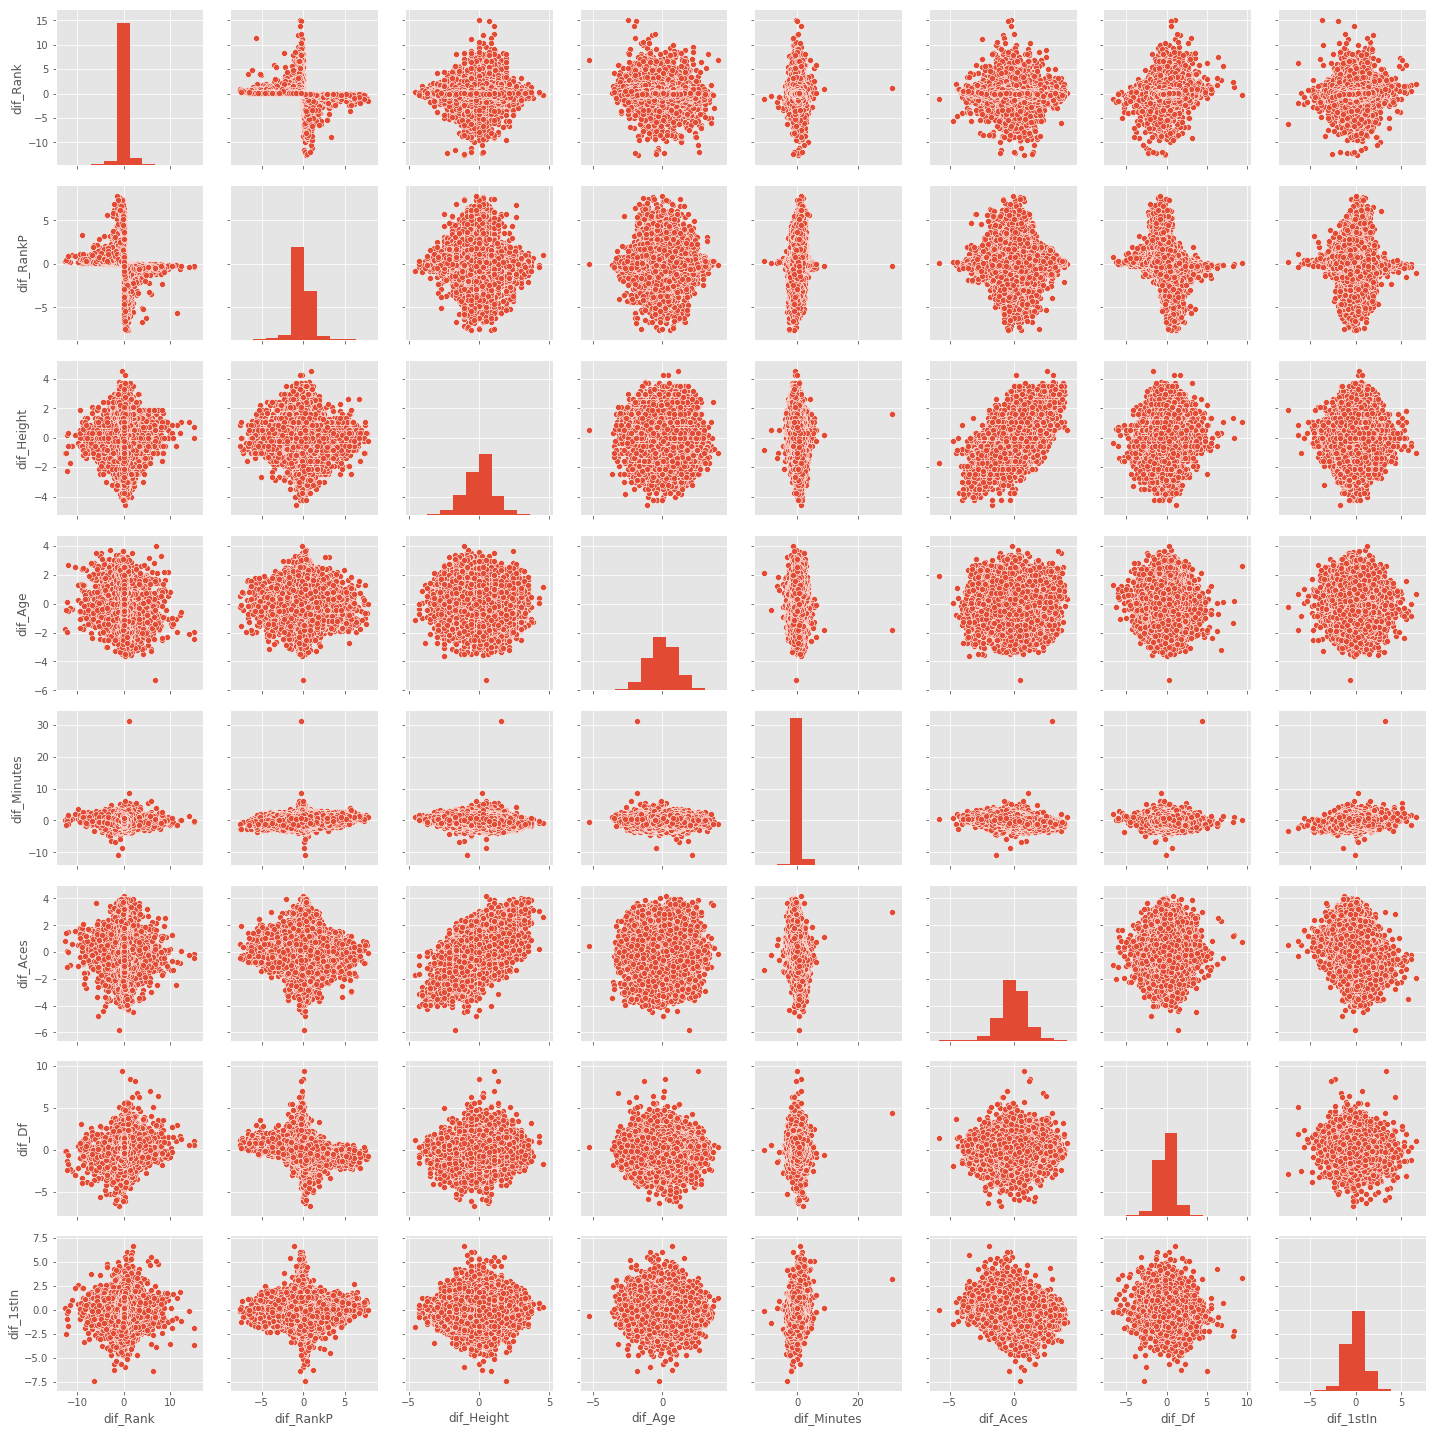

In [264]:
plt.figure(figsize=(20,20))
sns.pairplot(X)

La relación más fuerte entre variables parece que existe entre el número de Aces y la altura del jugador, lo cual parece evidente. Con double faults existe correlación aunque es menor.

Visualizacion 2:

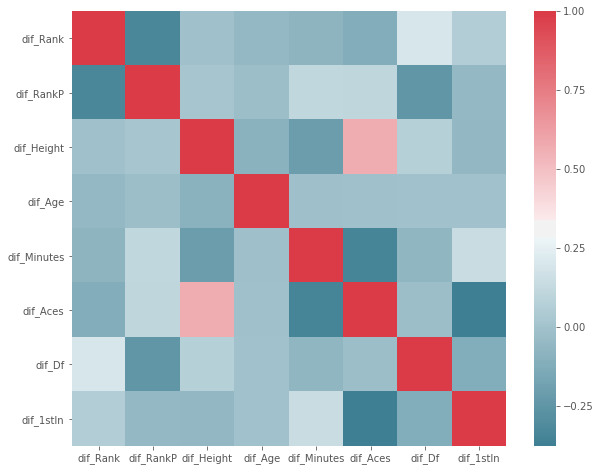

In [265]:
f, ax = plt.subplots(figsize=(10, 8))
corr = X.corr()
sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True),
            square=True, ax=ax)

Otra manera de visualizarlo:

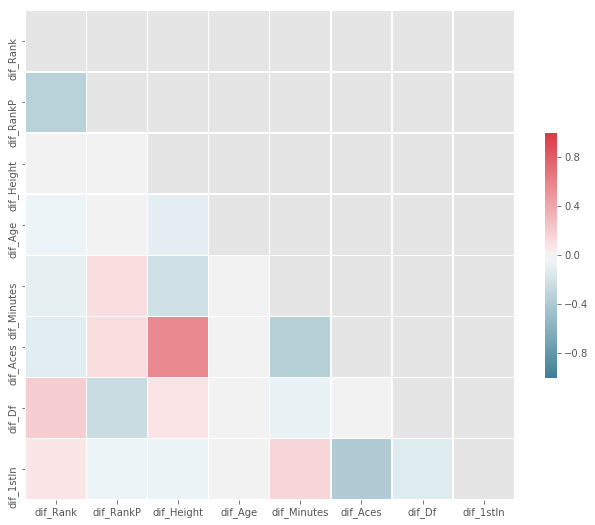

In [266]:
# Con seaborn
corr = X.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1, vmin=-1, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

 Gracias a esta matriz podemos ver ademas que también existe una realación fuerte entre el numero de double faults y el puesto en el Rank o las Rank poitns, cuanto mas alto es tu numero de Rank mayor la diferencia en el indice de double faults.
 Existen otras relaciones interesantes como que a mayor es la diferencia en numero de Aces, menor es la diferencia en duración del partido.

In [204]:
hwin = framesDCWO2['winner_ht'].mean()
hlos = framesDCWO2['loser_ht'].mean()
print hwin
print hlos

185.69106933
185.194876616


In [214]:
hwin_over100 = framesDCWO2[framesDCWO2['winner_rank'] > 50]
hwin_over100 = hwin_over100['winner_ht'].mean()
hwin_in100 = framesDCWO2[framesDCWO2['winner_rank'] < 50]
hwin_in100 = hwin_in100['winner_ht'].mean()
print hwin_over100
print hwin_in100

185.128737589
186.101088016


La altura media en los ganadaores es mayor que en los perdedores, este hecho se acentúa si filtramos la información entre los situados en las 50 primeras posiciones del ranking mundial y el resto.

## 5.4.1. KNNeighbours:

In [144]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

In [145]:
X = TennisDFnorm_X
y = TennisDF['Y']

In [146]:
clf = KNeighborsClassifier(n_neighbors = 5)

In [147]:
clf.fit(X, y)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform')

Vamos a separa ed df en train-test:

In [148]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

Vamos a ver la separación que ha hecho el sistema:

In [149]:
len(X_train)

31881

In [150]:
len(X_test)

10628

In [151]:
clf.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform')

Ahora vamos a valorar el accuracy del modelo:

In [152]:
accuracy_score(clf.predict(X_test), y_test)

0.8295069627399323

In [153]:
cross_val_score(clf,X,y,cv=10)

array([ 0.74106303,  0.7953904 ,  0.81157375,  0.84497765,  0.83368619,
        0.84733004,  0.8398024 ,  0.83623529,  0.84070588,  0.83482353])

In [154]:
np.average(cross_val_score(clf, X, y, cv=10))

0.82255881701416611

El accuracy es muy similar al de la regresión lineal.

#### Vamos a completar el analisis del resultado: Vamos a mostrar la matriz de confusion y a mostrar el indice de
#### Precision = True Positives / Total positives identified
#### Recall = True positives / Total positives

In [155]:
from sklearn.metrics import confusion_matrix

In [156]:
mat = confusion_matrix(y_test,clf.predict(X_test))
dfmat = pd.DataFrame(mat,index = ["Win","Lose"],
                  columns = ["Win","Lose"])

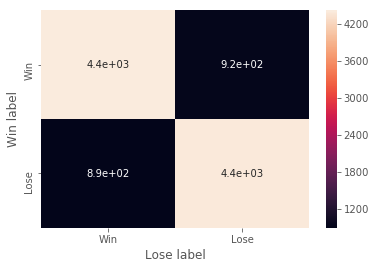

In [157]:
sns.heatmap(dfmat,annot=True)
plt.ylabel('Win label')
plt.xlabel('Lose label')

In [158]:
dfmat.describe

<bound method DataFrame.describe of        Win  Lose
Win   4420   924
Lose   888  4396>

In [159]:
### HAY QUE SACAR LOS PORCENTAJES DE PRECISION Y RECALL

#### Ahora vamos a averiguar el número óptimo de K:

In [160]:
scores=[]
for i in range(1,25):
    clf = KNeighborsClassifier(n_neighbors=i)
    scores.append(cross_val_score(clf,X,y,cv=4))

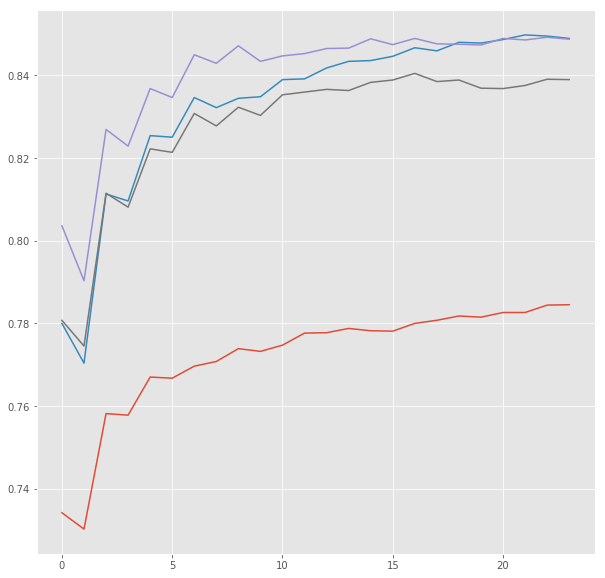

In [161]:
plt.figure(figsize=(10,10))
plt.plot(scores)
plt.show()

La mejora del accuracy es sustancial de 1 a 5. De 5 a 10 mejora en menor medida y apartir de aqui no se produce ninguna mejora más. El cálculo es muy lento, por lo que cuantos menos kneighbours utilicemos más rebajaremos el tiempo de proceso. El númer optimo se sitúa en el entorno de los 5 kneigbours.

## 5.4.2. SVM:

In [162]:
from sklearn.svm import SVC

In [163]:
X = TennisDFnorm_X
y = TennisDF['Y']

In [164]:
clf = SVC()
clf.fit(X, y)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [165]:
# ¿Podría ocurrir que al poner el kernel linear, el resultado empeore?
X_train, X_test, y_train, y_test = train_test_split(X,y)
clf = SVC(kernel='rbf')
clf.fit(X_train,y_train)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [166]:
accuracy_score(y_test,clf.predict(X_test))

0.85350018818216034

In [167]:
cross_val_score(clf,X,y,cv=5)

array([ 0.78831001,  0.84852405,  0.86307493,  0.85437007,  0.86025174])

#### Vamos a dibujar la curva ROC:

In [168]:
### PRUEBA CON IRIS

In [169]:
print(__doc__)

import numpy as np
import matplotlib.pyplot as plt
from itertools import cycle

from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from scipy import interp

# Import some data to play with
iris = datasets.load_iris()
X = iris.data
y = iris.target

# Binarize the output
y = label_binarize(y, classes=[0, 1, 2])
n_classes = y.shape[1]

# Add noisy features to make the problem harder
random_state = np.random.RandomState(0)
n_samples, n_features = X.shape
X = np.c_[X, random_state.randn(n_samples, 200 * n_features)]

# shuffle and split training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.5,
                                                    random_state=0)

# Learn to predict each class against the other
classifier = OneVsRestClassifier(svm.SVC(kernel='linear', probability=True,
                                 random_state=random_state))
y_score = classifier.fit(X_train, y_train).decision_function(X_test)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])


Automatically created module for IPython interactive environment


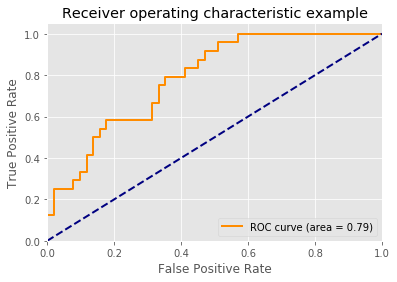

In [170]:
plt.figure()
lw = 2
plt.plot(fpr[2], tpr[2], color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[2])
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

In [171]:
##### 3º PRUEBA

## 5.5. Naive Bayes Classifier:

In [172]:
from sklearn.naive_bayes import GaussianNB

In [173]:
X = TennisDFnorm_X
y = TennisDF['Y']

In [174]:
gnb = GaussianNB()

In [175]:
y_pred = gnb.fit(X, y).predict(X)

In [176]:
print("Number of mislabeled points out of a total %d points : %d"
...       % (X.shape[0],(y != y_pred).sum()))

Number of mislabeled points out of a total 42509 points : 7871


## 5.6. Neuronal Network:

In [177]:
cd ..

/Users/NachoSJ/Documents/KSchool/Master DS IV/Proyecto/Tenis


In [178]:
import tensorflow as tf

In [179]:
from keras.models import Sequential
from keras.layers import Dense
import numpy
# fix random seed for reproducibility
numpy.random.seed(7)

Using TensorFlow backend.


## 5.7. Decision Tree:

In [180]:
from sklearn import tree

In [181]:
X = TennisDFnorm_X
y = TennisDF['Y']

In [182]:
clf = tree.DecisionTreeClassifier(max_depth=5)

In [183]:
X_train, X_test, y_train, y_test = train_test_split(X,y)
clf.fit(X_train,y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=5,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best')

In [184]:
accuracy_score(y_test,clf.predict(X_test))

0.81106511102747458

In [185]:
cross_val_score(clf,X,y,cv=5)

array([ 0.75984946,  0.80524521,  0.826491  ,  0.81684508,  0.82378544])

#### El resultado obtenido es mucho peor que con cualquiera de los otros clasificadores:

Vamos a intentar dibujar el árbol resultante y analizarlo:

In [186]:
import pydotplus
%matplotlib inline
from IPython.display import Image

In [187]:
colnames = X.columns

In [188]:
dot_data=tree.export_graphviz(clf, out_file=None, feature_names=['dif_Rank', 'dif_RankP', 'dif_Height', 'dif_Age', 'w_hand',
       'l_hand', 'dif_Minutes', 'dif_Aces', 'dif_Df', 'dif_1stIn'], filled=True)

In [189]:
graph = pydotplus.graph_from_dot_data(dot_data)

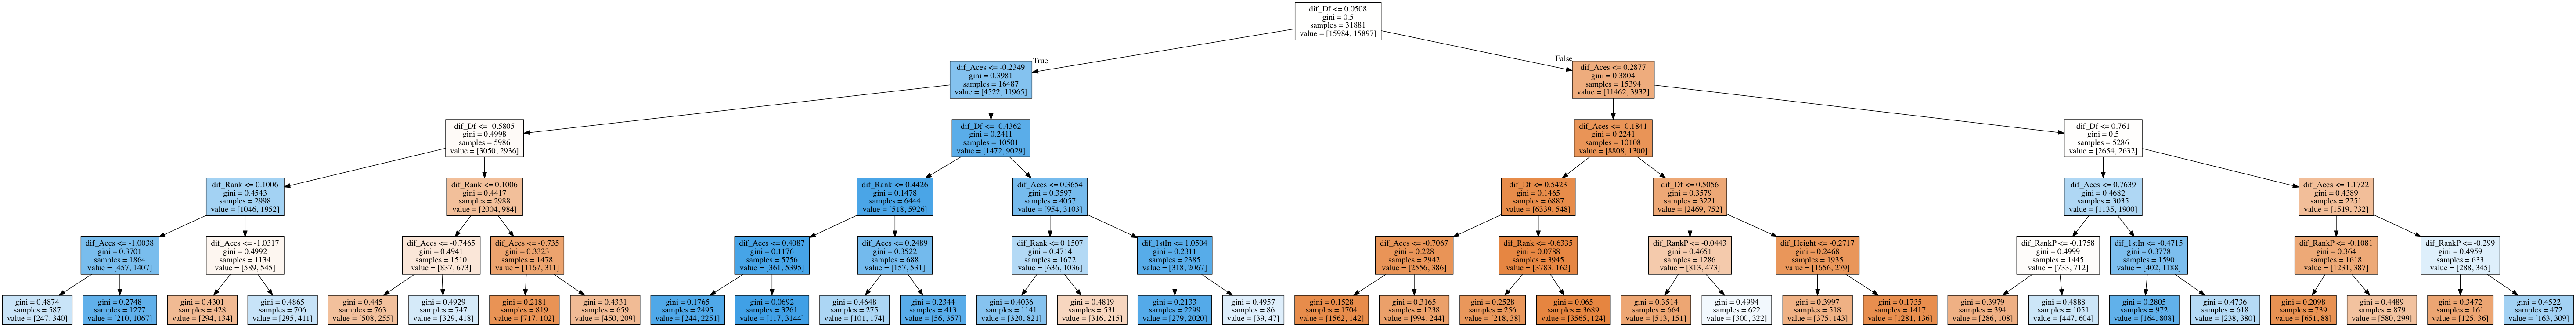

In [190]:
Image(graph.create_png())

## 6. Cross Validation:

### 6.1. Cross Validation:

### 6.2. Bagging:

### 6.3. Boosting:

In [191]:
from xgboost import XGBClassifier

In [192]:
X = TennisDFnorm_X
y = TennisDF['Y']

In [193]:
clf = XGBClassifier()

In [194]:
clf.fit(X,y)

XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=1,
       gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=100, nthread=-1,
       objective='binary:logistic', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=1)

In [195]:
cross_val_score(clf, X, y, cv=5)

array([ 0.78372339,  0.84558391,  0.85366427,  0.84143042,  0.84919421])

In [196]:
np.average(cross_val_score(clf, X, y, cv=30))

0.83867889574217946

In [197]:
clf.feature_importances_

array([ 0.08189655,  0.0775862 ,  0.14655173,  0.0316092 ,  0.01149425,
        0.01436782,  0.05747126,  0.26867816,  0.2341954 ,  0.07614943], dtype=float32)

#### Visualización 1:

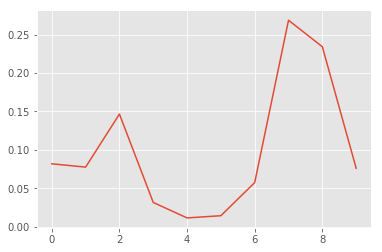

In [198]:
plt.plot(clf.feature_importances_)

Ahora voy a guardar una copia del modelo creado 

#### Visualización 2:

In [199]:
import plotly.offline as py
import plotly.graph_objs as go

In [200]:
py.init_notebook_mode()

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.


In [201]:
py.iplot([go.Histogram(x=clf.feature_importances_)])

#### Interpretación:

Las varibales predictoras con un mayor peso en el modelo son:
    - dif_Aces:   0.27
    - dif_Df:     0.23
    - dif_Height: 0.15
Esta interpretación es muy similar la obtenida en la regresión lineal:
    - dif_Df
    - dif_Aces
    - dif_Height

### 6.4. Combining models: